# Exploratory Data Analysis (EDA) on House Prices Dataset

## Introduction

In this project, we will perform **Exploratory Data Analysis (EDA)** on the **House Prices: Advanced Regression Techniques** dataset from Kaggle. The goal of EDA is to understand the dataset by examining its structure, cleaning the data, and visualizing key features. This process will help us uncover important patterns and relationships in the data, and provide insights into which features might be useful for predictive modeling in future steps.

We will follow these 7 key steps throughout the analysis:

### Steps of the EDA Process

1. **Understanding the Data**: This includes looking at the data types of various columns, understanding what each column represents, and identifying any key columns.
2. **Summary Statistics**: Calculating basic statistics like mean, median, mode, standard deviation, and range for numerical columns.
3. **Data Cleaning**: Identifying and handling missing values, outliers, and any inconsistencies in the data.
4. **Data Visualization**: Creating visualizations such as histograms, box plots, scatter plots, and correlation matrices to get a sense of the distributions, relationships, and patterns in the data.
5. **Feature Engineering**: Creating new features or modifying existing ones to better capture the underlying patterns in the data.
6. **Identifying Trends and Patterns**: Using the summary statistics and visualizations to identify any obvious trends, patterns, or anomalies in the data.
7. **Initial Hypothesis Testing**: Formulating and testing initial hypotheses about the data based on the observations from the EDA.

---

Let's begin by loading the dataset and reviewing its structure.

In [105]:
import pandas as pd
import numpy as np
df = pd.read_csv('../data/train.csv')

## Understanding the Data ##
In the first step of our Exploratory Data Analysis (EDA), we'll begin by examining the structure of the dataset and familiarizing ourselves with the information it provides. This involves inspecting the first few rows to understand the general layout, including the columns and their data types.
Additionally, we have helpful documentation (data_description.txt) available in the data folder that explains the meaning of each column. In real-world scenarios, this file would typically be produced after extensive exploration and collaboration with business stakeholders to gain a thorough understanding of each feature. For this project, I’ve reformatted the content of the data description into a data frame to make it easier to reference and work with. As we progress through the analysis, we will continue adding features to this data frame to enhance our understanding of the dataset.

In [106]:
def parse_data_description_to_dict(file_path):
    field_dict = {}
    current_field = None
    description = ''
    valid_options = {}

    with open(file_path, 'r') as f:
        lines = f.readlines()

    i = 0
    while i < len(lines):
        line = lines[i].rstrip('\n')

        # Skip empty lines
        if not line.strip():
            i += 1
            continue

        # Detect a new field (line does not start with space)
        if not line.startswith(' '):
            # Save the previous field's data
            if current_field:
                field_dict[current_field] = {
                    'Description': description.strip(),
                    'Valid Options': valid_options if valid_options else None
                }

            # Start parsing a new field
            # The line contains the field name and description
            # Field name and description are separated by a colon ':', if present
            if ':' in line:
                parts = line.split(':', 1)
                current_field = parts[0].strip()
                description = parts[1].strip()
            else:
                current_field = line.strip()
                description = ''
            valid_options = {}
            i += 1
        else:
            # Indented lines
            # Check for option lines starting with exactly 7 spaces
            if line.startswith('       '):  # 7 spaces
                option_line = line.strip()

                # Split the option code and its description
                if '\t' in option_line:
                    option_parts = option_line.split('\t', 1)
                else:
                    option_parts = option_line.split(None, 1)

                if len(option_parts) == 2:
                    code, desc = option_parts
                    valid_options[code.strip()] = desc.strip()
                else:
                    # Handle lines that are continuation of the description
                    description += ' ' + option_line.strip()
                i += 1
            else:
                # Lines with indentation but not exactly 7 spaces
                # May be continuation of description
                description += ' ' + line.strip()
                i += 1

    # Save data for the last field
    if current_field:
        field_dict[current_field] = {
            'Description': description.strip(),
            'Valid Options': valid_options if valid_options else None
        }

    return field_dict



# Example usage:
file_path = '../data/data_description.txt'  # Replace with your actual file path
data_description_dict = parse_data_description_to_dict(file_path)

# Print a field with options to verify
# print(data_description_dict)
import pprint
pprint.pprint(data_description_dict)

# Access specific features of a field
print("Description:", data_description_dict['Exterior1st']['Description'])
print("Valid Options:", data_description_dict['Exterior1st']['Valid Options'])

{'1stFlrSF': {'Description': 'First Floor square feet', 'Valid Options': None},
 '2ndFlrSF': {'Description': 'Second floor square feet', 'Valid Options': None},
 '3SsnPorch': {'Description': 'Three season porch area in square feet',
               'Valid Options': None},
 'Alley': {'Description': 'Type of alley access to property',
           'Valid Options': {'Grvl': 'Gravel',
                             'NA': 'No alley access',
                             'Pave': 'Paved'}},
 'Bedroom': {'Description': 'Bedrooms above grade (does NOT include basement '
                            'bedrooms)',
             'Valid Options': None},
 'BldgType': {'Description': 'Type of dwelling',
              'Valid Options': {'1Fam': 'Single-family Detached',
                                '2FmCon': 'Two-family Conversion; originally '
                                          'built as one-family dwelling',
                                'Duplx': 'Duplex',
                                'TwnhsE':

lets make sure fields in this dict are the same as actual dataset fields:

In [107]:
# Extract the field names from the data_description_dict
description_fields = set(data_description_dict.keys())

# Extract the column names from the DataFrame
df_fields = set(df.columns)

# Find fields that are in data_description_dict but not in df
in_description_not_df = description_fields - df_fields

# Find fields that are in df but not in data_description_dict
in_df_not_description = df_fields - description_fields

# Print the discrepancies
if in_description_not_df:
    print("Fields in data_description_dict but not in DataFrame:")
    for field in in_description_not_df:
        print(f"- {field}")
else:
    print("All fields in data_description_dict are present in the DataFrame.")

if in_df_not_description:
    print("\nFields in DataFrame but not in data_description_dict:")
    for field in in_df_not_description:
        print(f"- {field}")
else:
    print("All fields in the DataFrame are present in data_description_dict.")


Fields in data_description_dict but not in DataFrame:
- Bedroom
- Kitchen

Fields in DataFrame but not in data_description_dict:
- SalePrice
- Id
- KitchenAbvGr
- BedroomAbvGr


aside from Id and SalePrice, seems like we have a name discrepency for 2 columns. based on the descriptn these are the same with different names so I change them to KitchenAbvGr and BedroomAbvGr in the description dictionalry to solve this:

In [108]:
if 'Bedroom' in data_description_dict:
    data_description_dict['BedroomAbvGr'] = data_description_dict.pop('Bedroom')

if 'Kitchen' in data_description_dict:
    data_description_dict['KitchenAbvGr'] = data_description_dict.pop('Kitchen')


print(data_description_dict['BedroomAbvGr'])  # Verify the renamed Bedroom field
print(data_description_dict['KitchenAbvGr'])  # Verify the renamed Kitchen field

{'Description': 'Bedrooms above grade (does NOT include basement bedrooms)', 'Valid Options': None}
{'Description': 'Kitchens above grade', 'Valid Options': None}


## Feature Types Dictionary

Now that we have a data_description.txt file for this data, we can define a **feature_types** dictionary that categorizes each feature (column) in the dataset into one of several feature types. These types help us understand the nature of the data and guide how we should handle each feature during Exploratory Data Analysis (EDA) and machine learning (ML) preprocessing. The feature types include:

- **Continuous**: Numeric values that can take any value within a range (e.g., `LotArea`, `GrLivArea`).
- **Ordinal**: Categorical variables with a meaningful order (e.g., `OverallQual`, `ExterQual`).
- **Nominal**: Categorical variables without a meaningful order (e.g., `BldgType`, `Neighborhood`).
- **Boolean**: Binary values (Yes/No, 0/1) (e.g., `CentralAir`, `PavedDrive`).
- **Cyclic**: Variables that repeat in a cycle, such as months or days (e.g., `MoSold`).
- **Temporal**: Date or time-related features (e.g., `YearBuilt`, `YrSold`).

|**Feature Type**|**Description**|**Example in Dataset**|**EDA Handling**|**ML Handling**|
|-|-|-|-|-|
| **Continuous (Numerical)**  | Numerical values that can take any value within a range.                         | `LotArea`, `SalePrice`         | - Summary statistics (mean, median, std) <br> - Histograms <br> - Box plots <br> - Detect outliers               | - Normalize or standardize <br> - Handle outliers (capping, removal)                                      |
| **Ordinal (Ordered)**       | Categorical values with a meaningful order or ranking.                          | `OverallQual`, `ExterQual`     | - Mode and frequency distribution <br> - Bar plots                                                                | - Ordinal encoding <br> - Optional normalization (depending on the algorithm)                             |
| **Nominal (Unordered)**     | Categorical values with no inherent order or ranking.                           | `BldgType`, `Neighborhood`     | - Bar plots <br> - Pie charts                                                                                     | - One-hot encoding <br> - Target encoding (for high cardinality categories)                               |
| **Temporal (Date/Time)**    | Date or time-related features that can be decomposed into components.           | `YearBuilt`, `YrSold`          | - Extract components (year, month) <br> - Time series plots <br> - Trends over time                               | - Feature engineering (e.g., years since built) <br> - Cyclic encoding for months (sine/cosine)           |
| **Boolean (Binary)**        | Features with only two possible values, usually `0/1` or `True/False`.           | `CentralAir`, `PavedDrive`     | - Bar plots for distribution <br> - Count analysis                                                                | - Remain as binary <br> - No further encoding needed                                                      |
| **High Cardinality**        | Categorical features with a large number of distinct values.                     | `Neighborhood` (if many values)| - Frequency distribution <br> - Bar plots                                                                         | - Target encoding <br> - Frequency encoding                                                               |
| **Cyclic Features**         | Features where the values repeat in a cycle (e.g., days, months).                | `MoSold`                       | - Time series plots <br> - Histograms or bar plots                                                                | - Cyclic encoding using sine and cosine transformation     

### Purpose of the Feature Types Dictionary

The **feature_types** dictionary provides a structured way to understand how each column should be treated. This categorization is crucial because different types of features require different handling in both EDA and ML:

1. **EDA (Exploratory Data Analysis)**:
   - Continuous features should be analyzed using summary statistics like mean, median, standard deviation, and visualized using histograms and box plots.
   - Ordinal features can be visualized using bar plots to understand how the data is distributed across the ordered categories.
   - Nominal features can also be visualized with bar plots, but since they have no inherent order, the analysis should focus on frequency counts.
   - Boolean features (binary) can be analyzed through bar plots and summary statistics like the ratio of `True`/`False` or `0`/`1`.
   - Temporal features often need to be decomposed into components (e.g., extracting the year or calculating the number of years since a specific event), while cyclic features like `MoSold` can be analyzed as periodic patterns (e.g., through sine and cosine transformations).

2. **Machine Learning Preprocessing**:
   - **Continuous features**: These often require **normalization** (scaling to a range of 0-1) or **standardization** (scaling to a mean of 0 and standard deviation of 1) before being used in models.
   - **Ordinal features**: Should be **ordinally encoded**, converting categories into integer values based on their order (e.g., 1 = Poor, 2 = Fair, 3 = Good, etc.).
   - **Nominal features**: Should be transformed using **one-hot encoding**, where each category is converted into a binary feature, or **target encoding** in cases where high cardinality is present.
   - **Boolean features**: Usually remain binary (`0`/`1`), though some algorithms may require them to be encoded as `True`/`False` or similar.
   - **Cyclic features**: Should be encoded using **sine and cosine transformations** to represent their cyclical nature, especially in machine learning algorithms that may not handle cyclical data well.
   - **Temporal features**: Often require additional **feature engineering**, such as calculating the time since a specific event (e.g., years since the house was built) or converting date information into components (e.g., year, month).

### Future Uses

By maintaining this **feature_types** dictionary, we can streamline and automate many of the preprocessing tasks that would otherwise be manual and error-prone. This dictionary allows us to:
- Apply different transformations (e.g., normalization, encoding) based on feature type.
- Easily refer to the feature types for visualizing and analyzing the data.
- Simplify the process of building machine learning pipelines by automatically selecting the correct preprocessing steps for each feature type.

This will ensure that our EDA and machine learning models are both **efficient** and **effective**, tailored to the specific types of data we are working with.


In [149]:
feature_types = {
    'MSSubClass': 'nominal',          # Type of dwelling (ordered categories)
    'MSZoning': 'nominal',            # General zoning classification
    'LotFrontage': 'continuous',      # Linear feet of street connected to property
    'LotArea': 'continuous',          # Lot size in square feet
    'Street': 'nominal',              # Type of road access to property
    'Alley': 'nominal',               # Type of alley access
    'LotShape': 'ordinal',            # General shape of property (ordered by regularity)
    'LandContour': 'ordinal',         # Flatness of the property
    'Utilities': 'nominal',           # Type of utilities available
    'LotConfig': 'ordinal',           # Lot configuration
    'LandSlope': 'ordinal',           # Slope of property (ordered by severity)
    'Neighborhood': 'nominal',        # Physical locations within Ames city limits
    'Condition1': 'nominal',          # Proximity to various conditions
    'Condition2': 'nominal',          # Proximity to various conditions (if more than one is present)
    'BldgType': 'nominal',            # Type of dwelling
    'HouseStyle': 'nominal',          # Style of dwelling
    'OverallQual': 'ordinal',         # Rates the overall material and finish of the house (1 to 10)
    'OverallCond': 'ordinal',         # Rates the overall condition of the house (1 to 10)
    'YearBuilt': 'temporal',          # Original construction date
    'YearRemodAdd': 'temporal',       # Remodel date
    'RoofStyle': 'nominal',           # Type of roof
    'RoofMatl': 'nominal',            # Roof material
    'Exterior1st': 'nominal',         # Exterior covering on house
    'Exterior2nd': 'nominal',         # Exterior covering on house (if more than one material)
    'MasVnrType': 'nominal',          # Masonry veneer type
    'MasVnrArea': 'continuous',       # Masonry veneer area in square feet
    'ExterQual': 'ordinal',           # Evaluates the quality of the material on the exterior
    'ExterCond': 'ordinal',           # Evaluates the present condition of the material on the exterior
    'Foundation': 'nominal',          # Type of foundation
    'BsmtQual': 'ordinal',            # Evaluates the height of the basement
    'BsmtCond': 'ordinal',            # Evaluates the general condition of the basement
    'BsmtExposure': 'ordinal',        # Refers to walkout or garden level walls
    'BsmtFinType1': 'ordinal',        # Rating of basement finished area
    'BsmtFinSF1': 'continuous',       # Type 1 finished square feet in basement
    'BsmtFinType2': 'ordinal',        # Rating of basement finished area (if multiple types)
    'BsmtFinSF2': 'continuous',       # Type 2 finished square feet in basement
    'BsmtUnfSF': 'continuous',        # Unfinished square feet of basement area
    'TotalBsmtSF': 'continuous',      # Total square feet of basement area
    'Heating': 'nominal',             # Type of heating
    'HeatingQC': 'ordinal',           # Heating quality and condition
    'CentralAir': 'boolean',          # Central air conditioning (Y/N)
    'Electrical': 'nominal',          # Electrical system
    '1stFlrSF': 'continuous',         # First floor square feet
    '2ndFlrSF': 'continuous',         # Second floor square feet
    'LowQualFinSF': 'continuous',     # Low quality finished square feet (all floors)
    'GrLivArea': 'continuous',        # Above grade (ground) living area square feet
    'BsmtFullBath': 'continuous',     # Basement full bathrooms
    'BsmtHalfBath': 'continuous',     # Basement half bathrooms
    'FullBath': 'continuous',         # Full bathrooms above grade
    'HalfBath': 'continuous',         # Half baths above grade
    'BedroomAbvGr': 'continuous',     # Bedrooms above grade
    'KitchenAbvGr': 'continuous',     # Kitchens above grade
    'KitchenQual': 'ordinal',         # Kitchen quality
    'TotRmsAbvGrd': 'continuous',     # Total rooms above grade (does not include bathrooms)
    'Functional': 'ordinal',          # Home functionality (ordered)
    'Fireplaces': 'continuous',       # Number of fireplaces
    'FireplaceQu': 'ordinal',         # Fireplace quality
    'GarageType': 'nominal',          # Garage location
    'GarageYrBlt': 'temporal',        # Year garage was built
    'GarageFinish': 'ordinal',        # Interior finish of the garage
    'GarageCars': 'continuous',       # Size of garage in car capacity
    'GarageArea': 'continuous',       # Size of garage in square feet
    'GarageQual': 'ordinal',          # Garage quality
    'GarageCond': 'ordinal',          # Garage condition
    'PavedDrive': 'boolean',          # Paved driveway (Y/N)
    'WoodDeckSF': 'continuous',       # Wood deck area in square feet
    'OpenPorchSF': 'continuous',      # Open porch area in square feet
    'EnclosedPorch': 'continuous',    # Enclosed porch area in square feet
    '3SsnPorch': 'continuous',        # Three season porch area in square feet
    'ScreenPorch': 'continuous',      # Screen porch area in square feet
    'PoolArea': 'continuous',         # Pool area in square feet
    'PoolQC': 'ordinal',              # Pool quality
    'Fence': 'nominal',               # Fence quality
    'MiscFeature': 'nominal',         # Miscellaneous feature not covered in other categories
    'MiscVal': 'continuous',          # $Value of miscellaneous feature
    'MoSold': 'cyclic',               # Month Sold (cyclic, as months repeat)
    'YrSold': 'temporal',             # Year Sold
    'SaleType': 'nominal',            # Type of sale
    'SaleCondition': 'nominal'        # Condition of sale
}


lets add these to the data_description_dict

In [150]:
for field, feature_type in feature_types.items():
    # Check if the field exists in data_description_dict
    if field in data_description_dict:
        # Add the feature type to the corresponding field's dictionary
        data_description_dict[field]['Feature Type'] = feature_type
    else:
        print(f"Warning: {field} not found in data_description_dict")

## Feature Engineering Workflow with Train-Test Split and Consistent Transformations
### Feature Engineering
Feature engineering is the process of transforming raw data into meaningful features that can improve the performance of a machine learning model. In this exploratory data analysis (EDA) phase, feature engineering helps us understand the structure and characteristics of our data in greater depth, enabling us to identify patterns, improve data representation, and create new insights.

In this section, we will explore potential transformations, scaling, encoding, and interactions that can help enhance the dataset’s representation. By engineering features at this stage, we aim to gain insights that will ultimately inform the construction of a robust machine learning pipeline.

### Goals of Feature Engineering in EDA:
- Managing missing data
- Identify transformations to improve data distribution (e.g., log transformations).
- Scale features where necessary to ensure they are on comparable scales.
- Encode categorical variables to prepare them for modeling.
- Detect and address outliers appropriately.
- Generate new features that capture essential relationships or enhance predictive power.

### Feature Engineering Workflow
1. **Separate Train and Test Data**  
   For this analysis, the data is already provided in separate train and test files. This allows me to work directly on feature engineering without additional data splitting. To ensure consistency, I’ll focus on developing a transformation pipeline on the training data, which I can later apply to the test set during model evaluation.

2. **Set Up Custom Transformation Pipelines**  
  For each feature, as I identify the transformation needed (e.g., handling missing values, encoding, scaling), I'll levarage `sklearn`’s `Pipeline` to build custom pipelines specific to each type of transformation. Pipeline allows me to chain these steps together, applying each transformation in sequence for a given feature.

3. **Define the `ColumnTransformer` for Different Feature Types**
    Once I've decided on the transformations for each feature or feature group, ColumnTransformer lets me assign specific pipelines to specific columns.

   
4. **Fitting on Training Data Only**  
   I’m fitting the `ColumnTransformer` exclusively on the training data, preserving the integrity of the test set and avoiding any data leakage. This setup captures the necessary transformation parameters (like mean for scaling, categories for encoding) based on the training data alone.

5. **Pipeline Preservation for Reuse**  
   Saving the fitted transformation pipeline is a key step here. It allows for easy application to new or unseen data, ensuring consistency in preprocessing across different datasets.

This approach reinforces reproducibility, maintains a clear separation between training and testing phases, and systematically applies feature engineering steps, supporting a robust evaluation of model performance.



## Scale features where necessary to ensure they are on comparable scales.


Let’s go through each step of feature engineering, focusing on how these techniques can provide deeper insights into the data in preparation for the next phase: building a machine learning model.

----

before we decide what to do with the missing values in each column it will help to visualize the data in each column based on the feature type.

### Visualization Functions

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to visualize continuous features
def visualize_continuous(column, df):
    # Calculations
    min_value = df[column].min()
    max_value = df[column].max()
    mean_value = df[column].mean()
 
    plt.figure(figsize=(10, 4))
    
    # Histogram
    plt.subplot(2, 2, 1)
    sns.histplot(df[column].dropna(), kde=True, bins=30)
    plt.title(f'Histogram of {column}')
    
    # Boxplot
    plt.subplot(2, 2, 2)
    sns.boxplot(x=df[column].dropna())
    # # Add swarm plot on top of the box plot
    # sns.swarmplot(x=df[column], color='black', alpha=0.7)
    plt.title(f'Boxplot of {column}')

    # Strip Plot
    plt.subplot(2, 2, 3)
    sns.stripplot(x=df[column], jitter=True)
    plt.title(f'Strip Plot of {column}')
    plt.xlabel(column)
    # Plot vertical lines for min, max, and mean
    plt.axvline(min_value, color='red', linestyle='--', label=f'Min: {min_value}')
    plt.axvline(max_value, color='green', linestyle='--', label=f'Max: {max_value}')
    plt.axvline(mean_value, color='blue', linestyle='-', label=f'Avg: {mean_value:.2f}')
    
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Function to visualize categorical features ('ordinal', 'nominal', 'boolean', 'cyclic')
def visualize_categorical(column, df):
    # Prepare data for pie chart
    category_counts = df[column].value_counts()
    missing_count = df[column].isna().sum()
    
    # Combine data for categories and missing values
    labels = list(category_counts.index)
    sizes = list(category_counts.values)
    colors = sns.color_palette("cool", len(labels))
    if missing_count > 0:
        labels.append('Missing')
        sizes.append(missing_count)
        colors.append('red')  # Add red color for missing values

    percentages = (np.array(sizes) / sum(sizes)) * 100  # Calculate percentages

    # sorted categories for box plot
    mean_prices = df.groupby(column)['SalePrice'].mean().sort_values()
    sorted_categories = mean_prices.index  # Categories sorted by mean SalePrice

    # Visualization
    plt.figure(figsize=(12, 10))
    
    # Bar plot
    plt.subplot(2, 2, 1)
    sns.countplot(x=column, data=df, order=sorted(df[column].dropna().unique()))
    plt.title(f'Count Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')

    # Box plot
    plt.subplot(2, 2, 2)
    sns.boxplot(x=column, y='SalePrice', data=df, order=sorted_categories)
    plt.title(f'SalePrice Distribution by {column}')
    plt.xlabel(column)
    plt.ylabel('SalePrice')

    # Pie chart
    plt.subplot(2, 2, 3)

    # Define a function to format percentages conditionally
    def autopct_format(pct):
        return f'{pct:.1f}%' if pct >= 4 else ''  # Show percentage if >= 4%

    wedges, texts, autotexts = plt.pie(
        sizes,
        autopct=autopct_format,
        startangle=90,
        colors=colors,
        textprops={'fontsize': 10},
    )
    plt.title(f'Percentage Distribution of {column} (Including Missing)')
    plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.

    # Legend in the 4th spot
    plt.subplot(2, 2, 4)
    plt.axis('off')  # Turn off the axes for the legend area
    plt.legend(
        handles=wedges,
        labels=[f"{label}: {size} ({percent:.1f}%)" for label, size, percent in zip(labels, sizes, percentages)],
        loc="center",
        fontsize=10,
        title=f"{column} Categories"
    )

    plt.tight_layout()
    plt.show()


# Function to visualize nominal features
def visualize_nominal(column, df):
    plt.figure(figsize=(10, 4))
    
    # Bar plot for categories
    sns.countplot(x=column, data=df)
    plt.title(f'Count Plot of {column}')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Function to visualize boolean features
def visualize_boolean(column, df):
    plt.figure(figsize=(6, 4))
    
    # Bar plot for binary features
    sns.countplot(x=column, data=df)
    plt.title(f'Count Plot of {column}')
    plt.show()

# Function to visualize cyclic features (like months)
def visualize_cyclic(column, df):
    plt.figure(figsize=(10, 4))
    
    # Bar plot for cyclic features
    sns.countplot(x=column, data=df)
    plt.title(f'Count Plot of {column} (Cyclic)')
    plt.show()

# Function to visualize temporal features
def visualize_temporal(column, df):
    plt.figure(figsize=(10, 4))
    
    # Line plot for temporal features
    sns.histplot(df[column].dropna(), kde=True, bins=30)
    plt.title(f'Histogram of {column} (Temporal)')
    plt.show()

In [152]:
def missing_data_percentage(field, df):
    # Calculate the total number of rows in the DataFrame
    total_rows = len(df)
    
    # Calculate the number of missing (null) values for the specified column
    missing_values = df[field].isnull().sum()
    
    # Calculate the percentage of missing values
    missing_percentage = (missing_values / total_rows) * 100
    
    return missing_percentage

In [153]:
def visualize_by_type(df, data_description_dict, field):
    feature_type = data_description_dict[field]['Feature Type']
    
    if feature_type == 'continuous':
        visualize_continuous(field, df)
    elif feature_type in ['ordinal', 'nominal', 'boolean', 'cyclic']:
        visualize_categorical(field, df)
    elif feature_type == 'temporal':
        visualize_temporal(field, df)
    else:
        print(f"Feature {field} has an unknown feature type.")

### Counting Missing Values Based on Field-Specific Criteria

This function, `count_missing_values`, counts missing values in a specified field based on the unique criteria defined in `data_description_dict`. 

- **Purpose**: Some fields may define missing values differently. For instance, some fields consider any value outside a list of valid options as missing, while others treat only `NaN` values as missing.
- **How It Works**:
  - For fields with **valid options** in `data_description_dict`, any value not in these options (including `NaN`) is counted as missing.
  - For fields **without valid options**, only `NaN` values are considered missing.
- **Output**: The function returns the count of missing values and the indices (row numbers) where these missing values are located.

This approach ensures that we handle missing values in a customized way, tailored to the specifics of each field.


In [154]:
def find_missing_values(df, field, data_description_dict):
    
    # Check if the field exists in the DataFrame
    if field not in df.columns:
        raise ValueError(f"The field '{field}' does not exist in the DataFrame.")

    feature_type = data_description_dict[field]['Feature Type']
    if feature_type == 'nominal':
        
        # Get the valid options for the field if available
        valid_options = data_description_dict.get(field, {}).get('Valid Options', None).keys()
    
        # Define missing values based on whether valid options are provided
        if valid_options:
            # Missing values are those not in valid options or NaN
            missing_series = df[field].apply(
                lambda x: pd.isnull(x) or (str(x) not in valid_options)
            )
        else:
            # If no valid options, consider NaN values as missing
            missing_series = df[field].isnull()
            
    if feature_type in ['continuous', 'ordinal', 'temporal', 'boolean']:
        missing_series = df[field].isnull()

    # Count missing values and build the list of dictionaries for missing values
    missing_values_dict = {index: df.loc[index, field] for index in missing_series[missing_series].index}
    # missing_values_list = [{index: df.loc[index, field]} for index in missing_series[missing_series].index]

    return missing_values_dict

## feature-by-feature Analysis
lets look into features one by one
### feature_summary function
todo: explain the feature_summary function...


In [155]:
def feature_summary(field):

    target_column = 'SalePrice'
    print("Feature: ")
    feature_type = data_description_dict[field]['Feature Type']  
    print(f"{field} ({feature_type}): {data_description_dict[field]['Description']}")
    if data_description_dict[field]['Valid Options']:
        # Print each key-value pair on a new line
        print("Valid Options: ")
        for key, value in data_description_dict[field]['Valid Options'].items():
            print(f"{key}: {value}")
        # print(f"Options: {data_description_dict[field]['Valid Options']}") 

    if feature_type == 'ordinal':
        # Calculate the mean target value for each category
        mean_prices = df.groupby(field)[target_column].mean().sort_values()

        # Print the results
        print(f"Mean {target_column} for each category in {field}:")
        for category, mean_price in mean_prices.items():
            print(f"  {category}: ${mean_price:,.2f}")
    
    missing_values_dict = find_missing_values(df, field, data_description_dict)
    missing_values_count = len(missing_values_dict)
    print('Count of missing values: ', missing_values_count)
    missing_percentage = (missing_values_count / len(df)) * 100
    print(f'Missing values percentage: {missing_percentage:.2f}%')
    if missing_values_count != 0:
        print('Missing value Types:')
        # Convert dictionary values to a Series for easy counting
        missing_series = pd.Series(missing_values_dict.values())
        # Count the occurrences of each unique missing value
        missing_counts = missing_series.value_counts(dropna=False) 
        for index, value in missing_counts.items():
            print(f"{index}: {value}")

    print("Data types and count: ")
    type_counts = df[field].apply(lambda x: type(x).__name__).value_counts()
    for dtype, count in type_counts.items():
        print(f"{dtype}: {count}")
    
    visualize_by_type(df, data_description_dict, field)



### Feature Engineering Plan

As I go over features one by one, I am gradually building a list called `feature_engineering_plan` to document the transformations needed for each feature. This structured guide outlines the specific handling required, including imputation, scaling, encoding, and other transformations to prepare each feature for modeling. The `feature_engineering_plan` enables a systematic approach, ensuring consistent and tailored preprocessing for each feature. Each entry provides a concise blueprint for handling missing values, applying custom transformations, and managing unique feature needs like binarization or outlier handling, ultimately supporting a clean, adaptable pipeline for model training and evaluation.


In [189]:
# Load the feature engineering plan from a JSON file
import json
def load_feature_engineering_plan(file_path):
    try:
        with open(file_path, 'r') as file:
            plan = json.load(file)
        print(f"Feature engineering plan loaded from {file_path}: ")
        print(plan)
        return plan
    except FileNotFoundError:
        print(f"No saved feature engineering plan found at {file_path}. Starting fresh.")
        return {}

feature_engineering_plan = load_feature_engineering_plan('../data/feature_engineering_plan.json')

Feature engineering plan loaded from ../data/feature_engineering_plan.json: 
{'MSZoning': {'imputer': None, 'scaler': None, 'encoder': 'OneHotEncoder'}}


### Helper widget to review features and decide on feature engineering

In [181]:
from ipywidgets import interact, widgets, VBox, HBox
from IPython.display import display, clear_output

# Function to dynamically display and edit feature engineering plan
def explore_and_submit_feature(feature):
    # Clear any previous output
    output = widgets.Output()
    clear_output(wait=True)
    
    feature_summary(feature)  # Display feature summary

    # Get existing values for the feature, if they exist
    existing_plan = feature_engineering_plan.get(feature, {})
    existing_imputer = existing_plan.get('imputer', None)
    existing_scaler = existing_plan.get('scaler', None)
    existing_encoder = existing_plan.get('encoder', None)
    
    # Create widgets for input
    imputer_widget = widgets.Dropdown(
        options=[None, 'mean', 'median', 'mode', 'constant', 'knn', 'missing_indicator'],
        value=existing_imputer,
        description='Imputer:',
        style={'description_width': 'initial'}
    )
    scaler_widget = widgets.Dropdown(
        options=[None, 'StandardScaler', 'MinMaxScaler', 'RobustScaler'],
        value=existing_scaler,
        description='Scaler:',
        style={'description_width': 'initial'}
    )
    encoder_widget = widgets.Dropdown(
        options=[None, 'OneHotEncoder', 'LabelEncoder', 'OrdinalEncoder'],
        value=existing_encoder,
        description='Encoder:',
        style={'description_width': 'initial'}
    )
    submit_button = widgets.Button(description='Submit')

    # Function to handle button click
    def submit_feature_plan(_):
        feature_engineering_plan[feature] = {
            'imputer': imputer_widget.value,
            'scaler': scaler_widget.value,
            'encoder': encoder_widget.value
        }
        # Show the confirmation message
        with output:
            clear_output(wait=True)
            print(f"Feature plan saved for {feature}: {feature_engineering_plan[feature]}")
        # display(output)

    # Link button to function
    submit_button.on_click(submit_feature_plan)
    
    # Display widgets
    # display(VBox([HBox([imputer_widget, scaler_widget, encoder_widget]), submit_button, output]))
    # Display widgets
    display(VBox([
        HBox([imputer_widget, scaler_widget, encoder_widget]),
        HBox([submit_button], layout=widgets.Layout(justify_content='center')),  # Center the button
        output
    ]))

# Create a dropdown for feature selection
feature_dropdown = widgets.Dropdown(
    options = data_description_dict.keys(),
    description = 'Feature:',
    style = {'description_width': 'initial'}
)

# Interactive function to explore and submit
interact(explore_and_submit_feature, feature=feature_dropdown);

interactive(children=(Dropdown(description='Feature:', options=('MSSubClass', 'MSZoning', 'LotFrontage', 'LotA…

In [188]:
print(feature_engineering_plan)

{'MSZoning': {'imputer': None, 'scaler': None, 'encoder': 'OneHotEncoder'}}


In [187]:
# Save the feature engineering plan to a JSON file
def save_feature_engineering_plan(plan, file_path):
    with open(file_path, 'w') as file:
        json.dump(plan, file, indent=4)
    print(f"Feature engineering plan saved to {file_path}")

save_feature_engineering_plan(feature_engineering_plan, '../data/feature_engineering_plan.json')

Feature engineering plan saved to ../data/feature_engineering_plan.json


### Feature engineering review
explain different method that we are going to use and an example for each one here

In [ ]:
feature_summary('PoolArea')

In [ ]:
feature_engineering_plan.append({'PoolArea':{'imputer': 'mean','scaler': 'standard', 'encoder': 'one_hot'}})

In [ ]:
feature_summary('PoolQC')

In [ ]:
feature_engineering_plan.append({'PoolQC':{'imputer': 'mean','scaler': 'standard', 'encoder': 'one_hot'}})

In [ ]:
feature_summary('Fence')

In [ ]:
feature_engineering_plan.append({'Fence':{'imputer': 'mean','scaler': 'standard', 'encoder': 'one_hot'}})

In [ ]:
feature_summary('MiscFeature')

In [ ]:
feature_engineering_plan.append({'MiscFeature':{'imputer': 'mean','scaler': 'standard', 'encoder': 'one_hot'}})

In [ ]:
feature_summary('MiscVal')

In [ ]:
feature_engineering_plan.append({'MiscVal':{'imputer': 'mean','scaler': 'standard', 'encoder': 'one_hot'}})

In [ ]:
feature_summary('MoSold')

In [ ]:
feature_engineering_plan.append({'MoSold':{'imputer': 'mean','scaler': 'standard', 'encoder': 'one_hot'}})

In [ ]:
feature_summary('YrSold')

In [ ]:
feature_engineering_plan.append({'YrSold':{'imputer': 'mean','scaler': 'standard', 'encoder': 'one_hot'}})

In [ ]:
feature_summary('SaleType')

In [ ]:
feature_engineering_plan.append({'SaleType':{'imputer': 'mean','scaler': 'standard', 'encoder': 'one_hot'}})

In [ ]:
feature_summary('SaleCondition')

In [ ]:
feature_engineering_plan.append({'SaleCondition':{'imputer': 'mean','scaler': 'standard', 'encoder': 'one_hot'}})

In [37]:
import pandas as pd
import numpy as np

# Convert the list to a DataFrame
field = 'MSSubClass'
df1 = pd.DataFrame(list(df[field]), columns=['Value'])

# Add a column for data types
df1['Data Type'] = df1['Value'].apply(lambda x: type(x).__name__)

# Add a column for missing values status
df1['Is Missing'] = df1['Value'].apply(lambda x: pd.isnull(x))

# Display the table
print(df1)


      Value Data Type  Is Missing
0        60       int       False
1        20       int       False
2        60       int       False
3        70       int       False
4        60       int       False
...     ...       ...         ...
1455     60       int       False
1456     20       int       False
1457     70       int       False
1458     20       int       False
1459     20       int       False

[1460 rows x 3 columns]


## Data Cleaning

Data cleaning is an essential step in preparing our dataset for analysis. In this section, we will handle missing values, deal with inconsistencies, and prepare the data for further analysis.

### 1. Handle Missing Values

First, we need to check which columns contain missing values and how we can handle them. Missing values can be dropped, imputed with mean/median/mode, or treated in other ways depending on the data type and context. lets visualize the columns with missing values and also consider what percentage of the values are missing.


LotFrontage (continuous): Linear feet of street connected to property
Count of missing values:  259
Missing values percentage: 17.74%


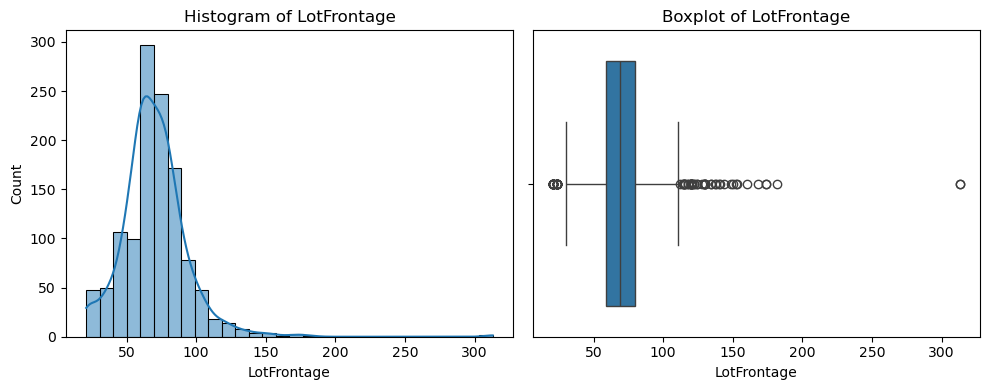

Alley (nominal): Type of alley access to property
Options: {'Grvl': 'Gravel', 'Pave': 'Paved', 'NA': 'No alley access'}
Count of missing values:  1369
Missing values percentage: 93.77%


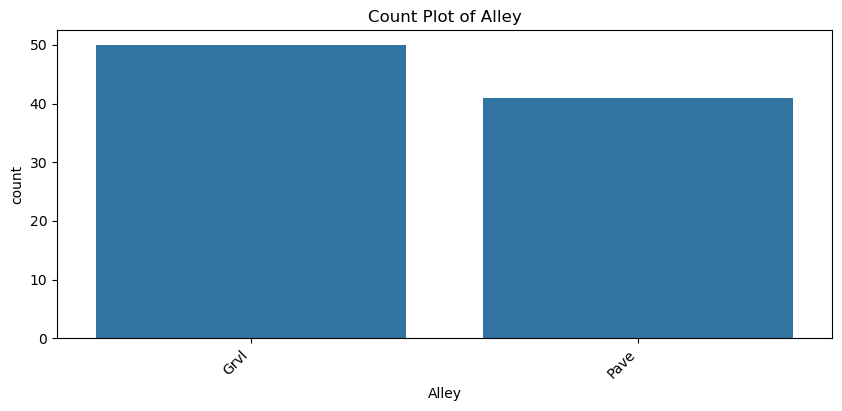

MasVnrType (nominal): Masonry veneer type
Options: {'BrkCmn': 'Brick Common', 'BrkFace': 'Brick Face', 'CBlock': 'Cinder Block', 'None': 'None', 'Stone': 'Stone'}
Count of missing values:  872
Missing values percentage: 59.73%


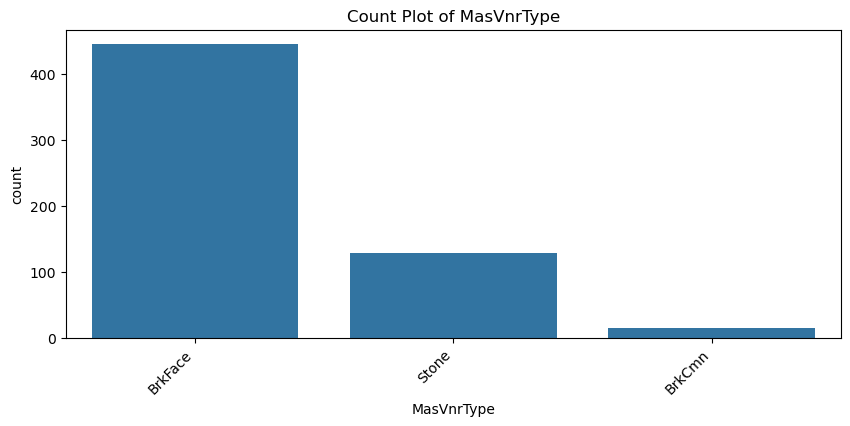

MasVnrArea (continuous): Masonry veneer area in square feet
Count of missing values:  8
Missing values percentage: 0.55%


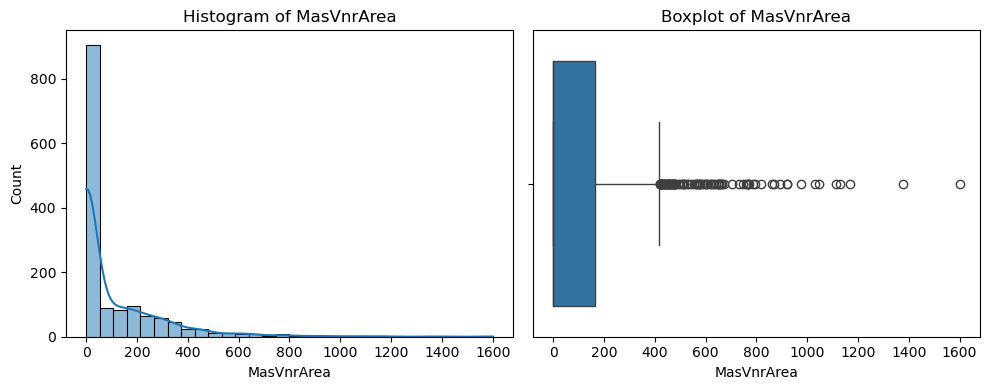

BsmtQual (ordinal): Evaluates the height of the basement
Options: {'Ex': 'Excellent (100+ inches)', 'Gd': 'Good (90-99 inches)', 'TA': 'Typical (80-89 inches)', 'Fa': 'Fair (70-79 inches)', 'Po': 'Poor (<70 inches', 'NA': 'No Basement'}
Count of missing values:  37
Missing values percentage: 2.53%


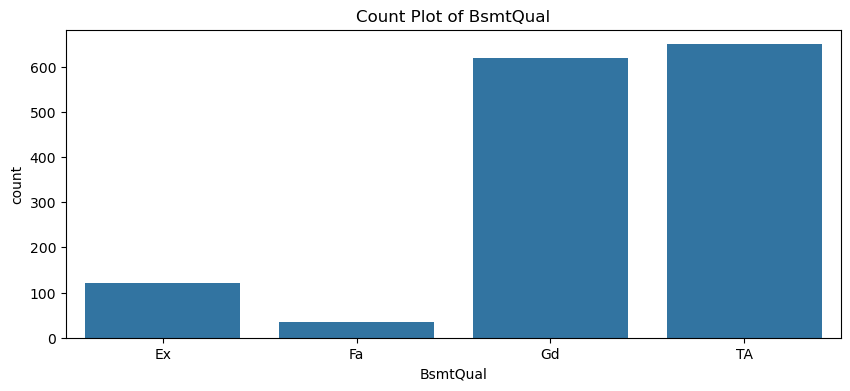

BsmtCond (ordinal): Evaluates the general condition of the basement
Options: {'Ex': 'Excellent', 'Gd': 'Good', 'TA': 'Typical - slight dampness allowed', 'Fa': 'Fair - dampness or some cracking or settling', 'Po': 'Poor - Severe cracking, settling, or wetness', 'NA': 'No Basement'}
Count of missing values:  37
Missing values percentage: 2.53%


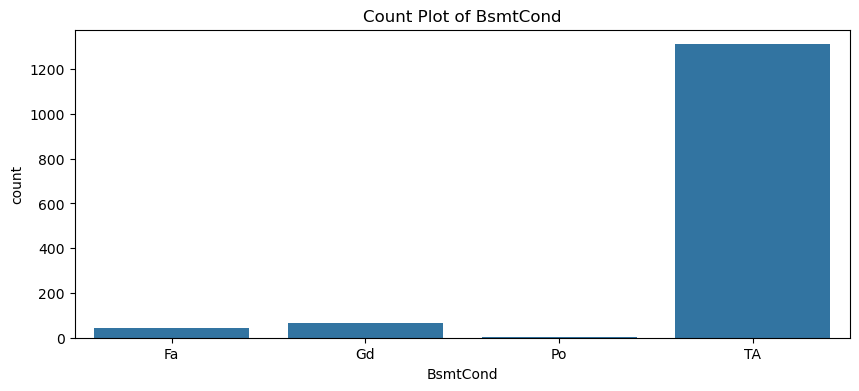

BsmtExposure (ordinal): Refers to walkout or garden level walls
Options: {'Gd': 'Good Exposure', 'Av': 'Average Exposure (split levels or foyers typically score average or above)', 'Mn': 'Mimimum Exposure', 'No': 'No Exposure', 'NA': 'No Basement'}
Count of missing values:  38
Missing values percentage: 2.60%


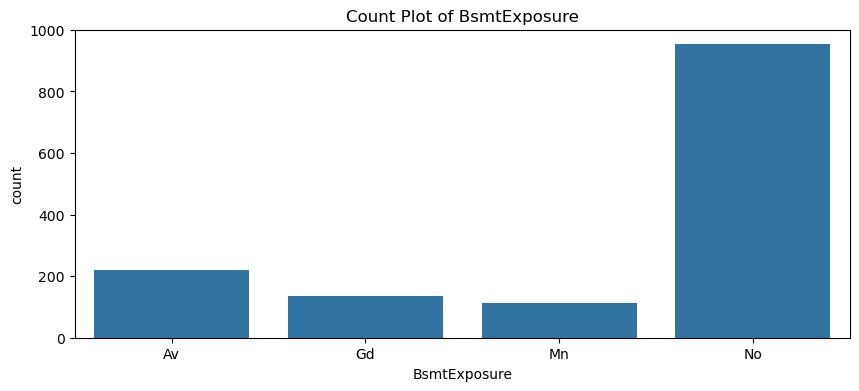

BsmtFinType1 (ordinal): Rating of basement finished area
Options: {'GLQ': 'Good Living Quarters', 'ALQ': 'Average Living Quarters', 'BLQ': 'Below Average Living Quarters', 'Rec': 'Average Rec Room', 'LwQ': 'Low Quality', 'Unf': 'Unfinshed', 'NA': 'No Basement'}
Count of missing values:  37
Missing values percentage: 2.53%


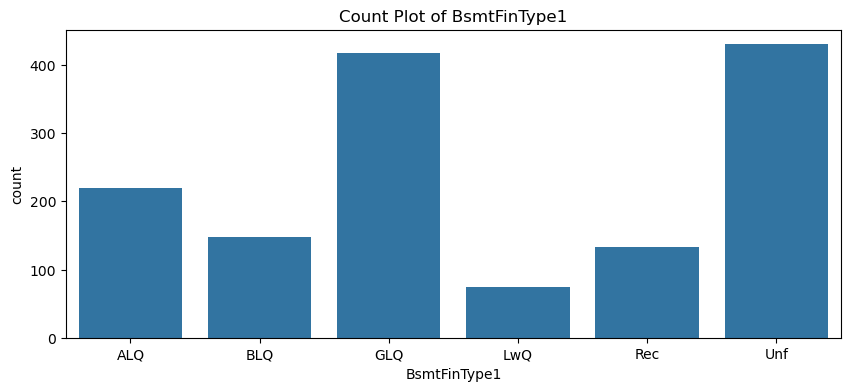

BsmtFinType2 (ordinal): Rating of basement finished area (if multiple types)
Options: {'GLQ': 'Good Living Quarters', 'ALQ': 'Average Living Quarters', 'BLQ': 'Below Average Living Quarters', 'Rec': 'Average Rec Room', 'LwQ': 'Low Quality', 'Unf': 'Unfinshed', 'NA': 'No Basement'}
Count of missing values:  38
Missing values percentage: 2.60%


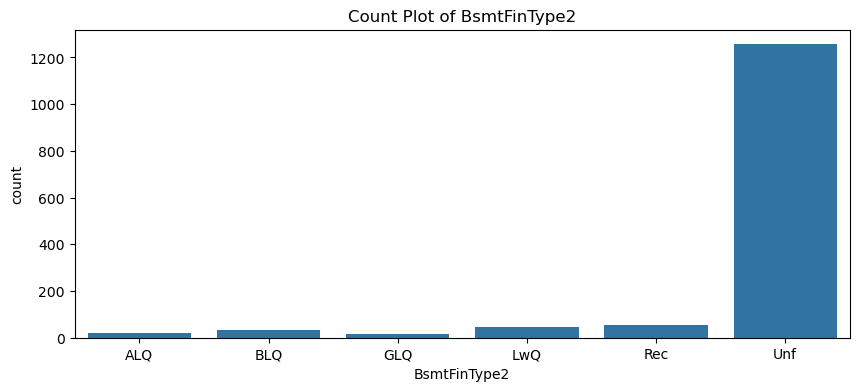

Electrical (nominal): Electrical system
Options: {'SBrkr': 'Standard Circuit Breakers & Romex', 'FuseA': 'Fuse Box over 60 AMP and all Romex wiring (Average)', 'FuseF': '60 AMP Fuse Box and mostly Romex wiring (Fair)', 'FuseP': '60 AMP Fuse Box and mostly knob & tube wiring (poor)', 'Mix': 'Mixed'}
Count of missing values:  1
Missing values percentage: 0.07%


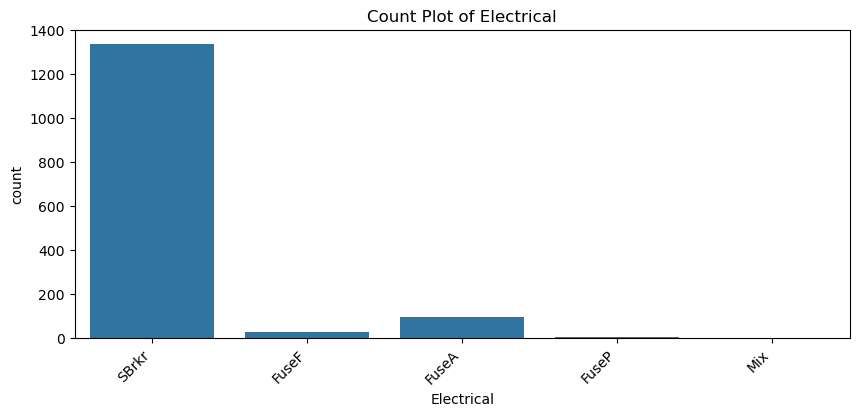

FireplaceQu (ordinal): Fireplace quality
Options: {'Ex': 'Excellent - Exceptional Masonry Fireplace', 'Gd': 'Good - Masonry Fireplace in main level', 'TA': 'Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement', 'Fa': 'Fair - Prefabricated Fireplace in basement', 'Po': 'Poor - Ben Franklin Stove', 'NA': 'No Fireplace'}
Count of missing values:  690
Missing values percentage: 47.26%


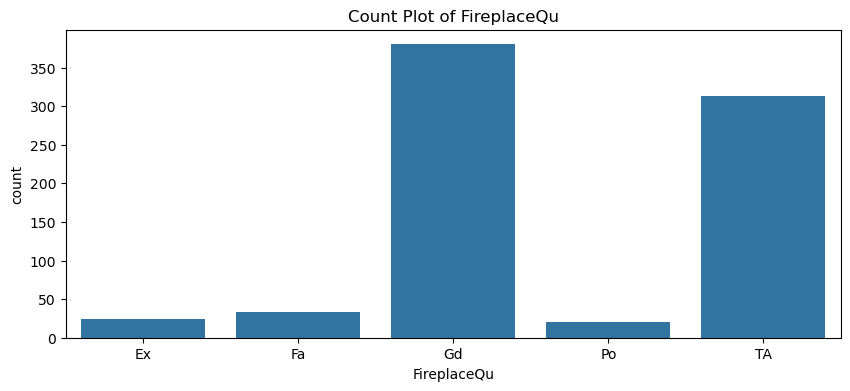

GarageType (nominal): Garage location
Options: {'2Types': 'More than one type of garage', 'Attchd': 'Attached to home', 'Basment': 'Basement Garage', 'BuiltIn': 'Built-In (Garage part of house - typically has room above garage)', 'CarPort': 'Car Port', 'Detchd': 'Detached from home', 'NA': 'No Garage'}
Count of missing values:  81
Missing values percentage: 5.55%


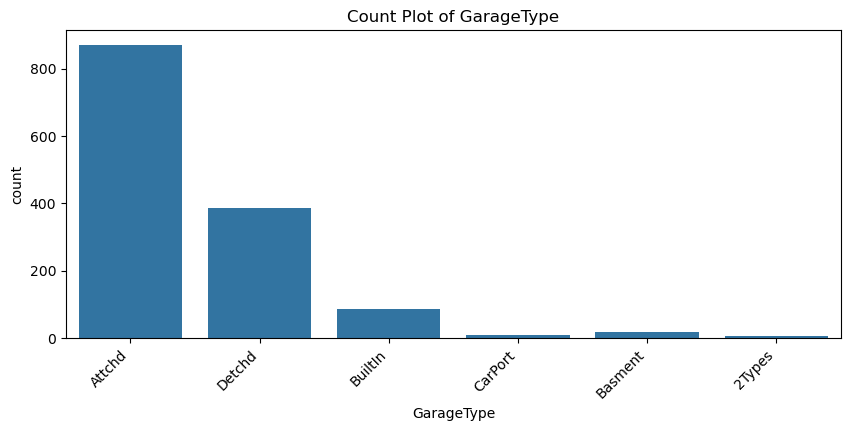

GarageYrBlt (temporal): Year garage was built
Count of missing values:  81
Missing values percentage: 5.55%


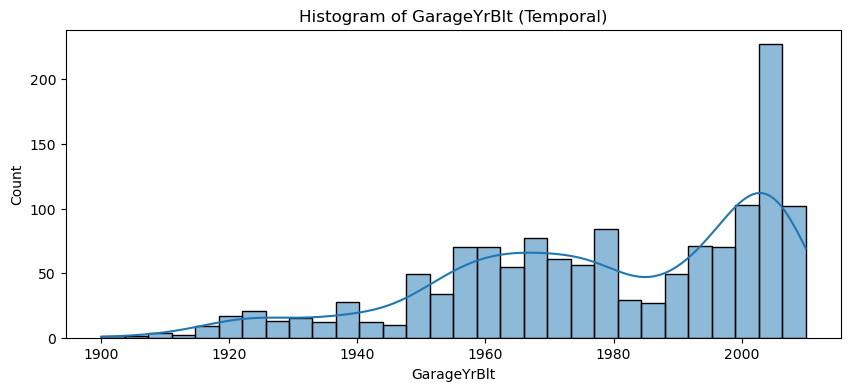

GarageFinish (ordinal): Interior finish of the garage
Options: {'Fin': 'Finished', 'RFn': 'Rough Finished', 'Unf': 'Unfinished', 'NA': 'No Garage'}
Count of missing values:  81
Missing values percentage: 5.55%


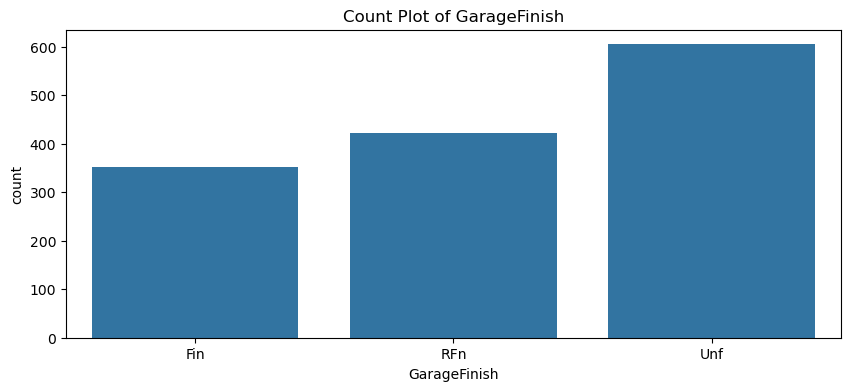

GarageQual (ordinal): Garage quality
Options: {'Ex': 'Excellent', 'Gd': 'Good', 'TA': 'Typical/Average', 'Fa': 'Fair', 'Po': 'Poor', 'NA': 'No Garage'}
Count of missing values:  81
Missing values percentage: 5.55%


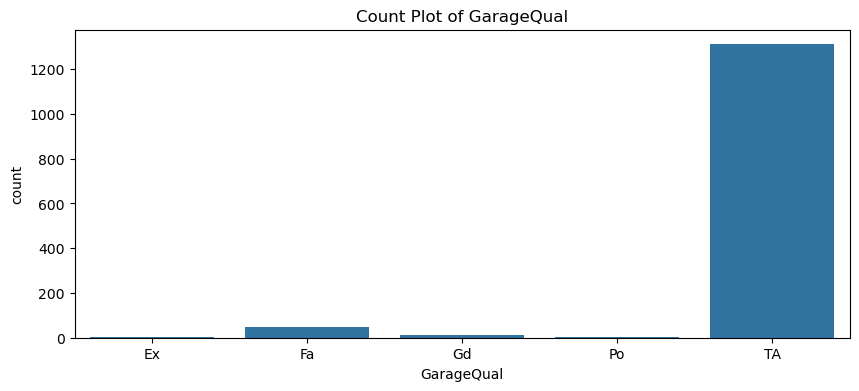

GarageCond (ordinal): Garage condition
Options: {'Ex': 'Excellent', 'Gd': 'Good', 'TA': 'Typical/Average', 'Fa': 'Fair', 'Po': 'Poor', 'NA': 'No Garage'}
Count of missing values:  81
Missing values percentage: 5.55%


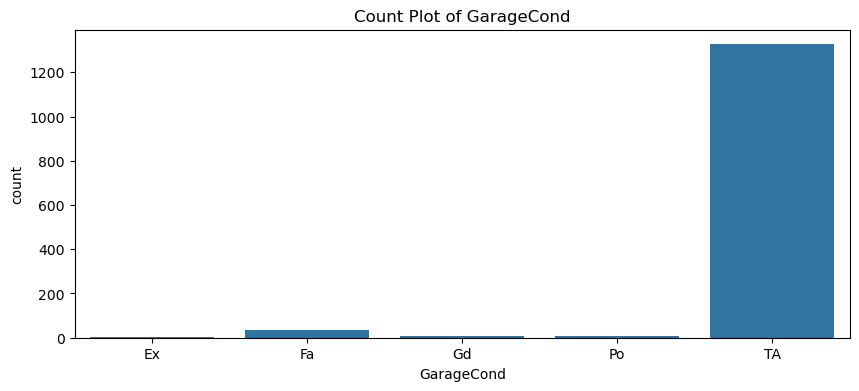

PoolQC (ordinal): Pool quality
Options: {'Ex': 'Excellent', 'Gd': 'Good', 'TA': 'Average/Typical', 'Fa': 'Fair', 'NA': 'No Pool'}
Count of missing values:  1453
Missing values percentage: 99.52%


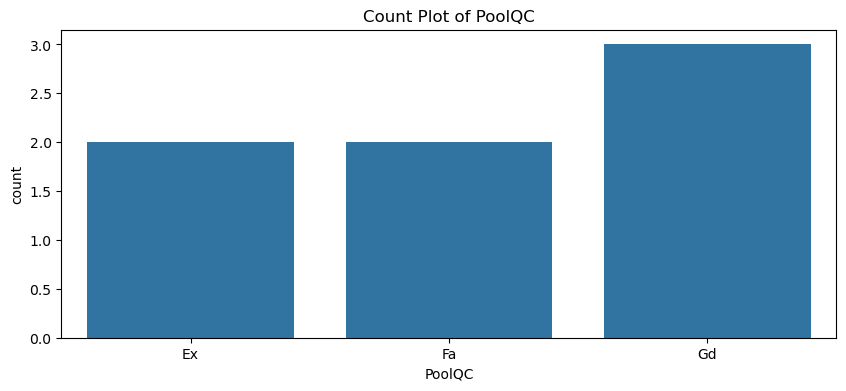

Fence (nominal): Fence quality
Options: {'GdPrv': 'Good Privacy', 'MnPrv': 'Minimum Privacy', 'GdWo': 'Good Wood', 'MnWw': 'Minimum Wood/Wire', 'NA': 'No Fence'}
Count of missing values:  1179
Missing values percentage: 80.75%


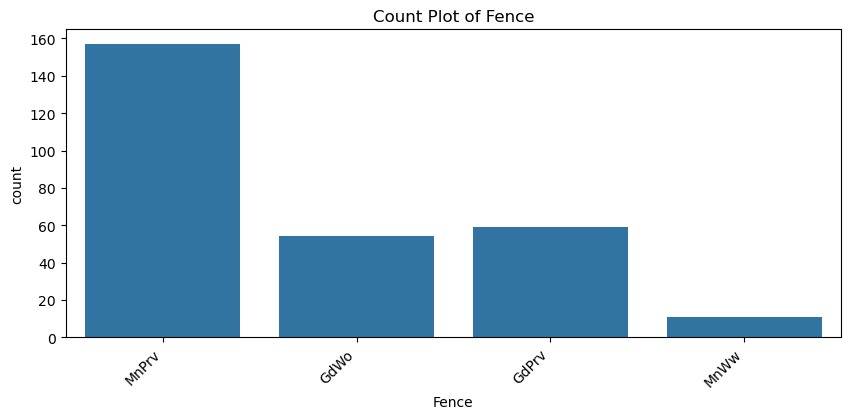

MiscFeature (nominal): Miscellaneous feature not covered in other categories
Options: {'Elev': 'Elevator', 'Gar2': '2nd Garage (if not described in garage section)', 'Othr': 'Other', 'Shed': 'Shed (over 100 SF)', 'TenC': 'Tennis Court', 'NA': 'None'}
Count of missing values:  1406
Missing values percentage: 96.30%


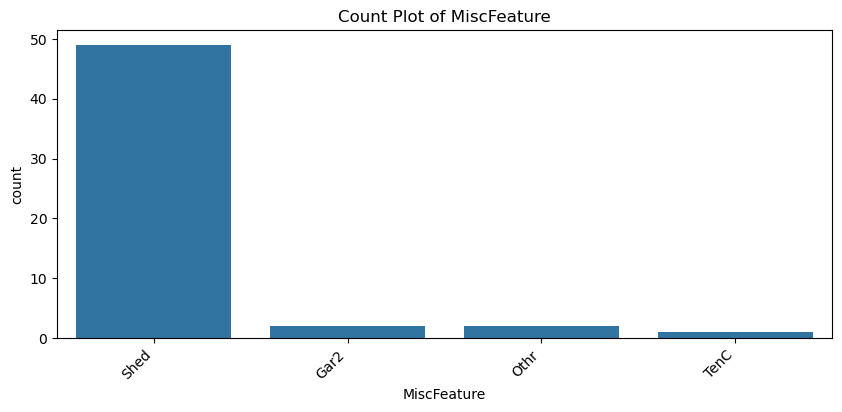

In [30]:
for field in data_description_dict:
    missing_values_count = df[field].isnull().sum()
    if missing_values_count > 0:
        feature_type = data_description_dict[field]['Feature Type']
    
        print(f"{field} ({feature_type}): {data_description_dict[field]['Description']}")
        if data_description_dict[field]['Valid Options']:
            print(f"Options: {data_description_dict[field]['Valid Options']}") 
        
        print('Count of missing values: ', missing_values_count)
        missing_percentage = (missing_values_count / len(df)) * 100
        print(f'Missing values percentage: {missing_percentage:.2f}%')
        visualize_by_type(df, data_description_dict, field)

In [32]:
print(list(df['LotFrontage']))
print(df['LotFrontage'].median())

[65.0, 80.0, 68.0, 60.0, 84.0, 85.0, 75.0, nan, 51.0, 50.0, 70.0, 85.0, nan, 91.0, nan, 51.0, nan, 72.0, 66.0, 70.0, 101.0, 57.0, 75.0, 44.0, nan, 110.0, 60.0, 98.0, 47.0, 60.0, 50.0, nan, 85.0, 70.0, 60.0, 108.0, 112.0, 74.0, 68.0, 65.0, 84.0, 115.0, nan, nan, 70.0, 61.0, 48.0, 84.0, 33.0, 66.0, nan, 52.0, 110.0, 68.0, 60.0, 100.0, 24.0, 89.0, 66.0, 60.0, 63.0, 60.0, 44.0, 50.0, nan, 76.0, nan, 72.0, 47.0, 81.0, 95.0, 69.0, 74.0, 85.0, 60.0, 21.0, nan, 50.0, 72.0, 60.0, 100.0, 32.0, 78.0, 80.0, nan, 121.0, 122.0, 40.0, 105.0, 60.0, 60.0, 85.0, 80.0, 60.0, 69.0, nan, 78.0, 73.0, 85.0, 77.0, nan, 77.0, 64.0, 94.0, nan, 75.0, 60.0, 50.0, 85.0, 105.0, 75.0, nan, 77.0, nan, 61.0, 34.0, nan, 74.0, 90.0, 65.0, nan, 50.0, 75.0, 55.0, 48.0, 60.0, nan, 55.0, 69.0, 69.0, 88.0, nan, 75.0, nan, 78.0, 80.0, nan, 82.0, 73.0, 65.0, 70.0, 78.0, 71.0, 78.0, 70.0, 24.0, 51.0, nan, 63.0, nan, 120.0, 107.0, nan, nan, 84.0, 60.0, 60.0, 92.0, 100.0, 134.0, nan, 110.0, 95.0, 55.0, 40.0, 62.0, nan, 86.0, 62.0

In [33]:
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())
print(list(df['LotFrontage']))

[65.0, 80.0, 68.0, 60.0, 84.0, 85.0, 75.0, 69.0, 51.0, 50.0, 70.0, 85.0, 69.0, 91.0, 69.0, 51.0, 69.0, 72.0, 66.0, 70.0, 101.0, 57.0, 75.0, 44.0, 69.0, 110.0, 60.0, 98.0, 47.0, 60.0, 50.0, 69.0, 85.0, 70.0, 60.0, 108.0, 112.0, 74.0, 68.0, 65.0, 84.0, 115.0, 69.0, 69.0, 70.0, 61.0, 48.0, 84.0, 33.0, 66.0, 69.0, 52.0, 110.0, 68.0, 60.0, 100.0, 24.0, 89.0, 66.0, 60.0, 63.0, 60.0, 44.0, 50.0, 69.0, 76.0, 69.0, 72.0, 47.0, 81.0, 95.0, 69.0, 74.0, 85.0, 60.0, 21.0, 69.0, 50.0, 72.0, 60.0, 100.0, 32.0, 78.0, 80.0, 69.0, 121.0, 122.0, 40.0, 105.0, 60.0, 60.0, 85.0, 80.0, 60.0, 69.0, 69.0, 78.0, 73.0, 85.0, 77.0, 69.0, 77.0, 64.0, 94.0, 69.0, 75.0, 60.0, 50.0, 85.0, 105.0, 75.0, 69.0, 77.0, 69.0, 61.0, 34.0, 69.0, 74.0, 90.0, 65.0, 69.0, 50.0, 75.0, 55.0, 48.0, 60.0, 69.0, 55.0, 69.0, 69.0, 88.0, 69.0, 75.0, 69.0, 78.0, 80.0, 69.0, 82.0, 73.0, 65.0, 70.0, 78.0, 71.0, 78.0, 70.0, 24.0, 51.0, 69.0, 63.0, 69.0, 120.0, 107.0, 69.0, 69.0, 84.0, 60.0, 60.0, 92.0, 100.0, 134.0, 69.0, 110.0, 95.0, 55.0

Here’s a dictionary based on the data description file that provides tailored methods for handling missing data in each column. The imputation strategy is chosen based on the type and meaning of each feature, as outlined in our discussion. 
there are different methods to handle the missing data. and it depends on each field. based on the percentage of missing data and the undrestanding we gained for each field, here is how I'm gonna handle missing data for this case:

In [16]:
missing_data_handling = {
    'LotFrontage': 'median',
    'Alley': 'NA',
    'MasVnrType': 'None',
    'MasVnrArea': 0,
    'BsmtQual': 'NA',
    'BsmtCond': 'NA',
    'BsmtExposure': 'NA',
    'BsmtFinType1': 'NA',
    'BsmtFinType2': 'NA',
    'Electrical': 'mode',
    'FireplaceQu': 'NA',
    'GarageType': 'NA',
    'GarageYrBlt': 'YearBuilt',
    'GarageFinish': 'NA',
    'GarageQual': 'NA',
    'GarageCond': 'NA',
    'PoolQC': 'NA',
    'Fence': 'NA',
    'MiscFeature': 'NA'
}

In [34]:
def handle_missing_data(df, missing_data_handling):
    for column, method in missing_data_handling.items():
        if method == 'None':
            # Replace missing values with 'None'
            df[column] = df[column].fillna('None')
        elif method == 'NA':
            # Replace missing values with 'NA'
            df[column] = df[column].fillna('NA')
        elif method == 0:
            # Replace missing values with 0 for continuous or numeric features
            df[column] = df[column].fillna(0)
        elif method == 'mode':
            # Replace missing values with the mode (most frequent value)
            df[column] = df[column].fillna(df[column].mode()[0])
        elif method == 'median':
            # Replace missing values with the median for continuous features
            df[column] = df[column].fillna(df[column].median())
        elif method == 'delete':
            # Drop rows where values are missing in this column
            df = df.dropna(subset=[column])
        elif method == 'YearBuilt':
            # Replace missing values with values from 'YearBuilt' for that row
            df[column] = df.apply(lambda row: row['YearBuilt'] if pd.isnull(row[column]) else row[column], axis=1)
        else:
            print(f"Unknown method '{method}' for column '{column}'")
    
    return df

# Apply the function to handle missing data
df = handle_missing_data(df, missing_data_handling)

# check if there is any missing data
missing_data_columns = df.columns[df.isnull().any()]

# Check if there are any columns with missing data
if not missing_data_columns.empty:
    print("Columns with missing data:", missing_data_columns.tolist())
else:
    print("No missing data found.")



No missing data found.


In [35]:
print(list(df['LotFrontage']))

[65.0, 80.0, 68.0, 60.0, 84.0, 85.0, 75.0, 69.0, 51.0, 50.0, 70.0, 85.0, 69.0, 91.0, 69.0, 51.0, 69.0, 72.0, 66.0, 70.0, 101.0, 57.0, 75.0, 44.0, 69.0, 110.0, 60.0, 98.0, 47.0, 60.0, 50.0, 69.0, 85.0, 70.0, 60.0, 108.0, 112.0, 74.0, 68.0, 65.0, 84.0, 115.0, 69.0, 69.0, 70.0, 61.0, 48.0, 84.0, 33.0, 66.0, 69.0, 52.0, 110.0, 68.0, 60.0, 100.0, 24.0, 89.0, 66.0, 60.0, 63.0, 60.0, 44.0, 50.0, 69.0, 76.0, 69.0, 72.0, 47.0, 81.0, 95.0, 69.0, 74.0, 85.0, 60.0, 21.0, 69.0, 50.0, 72.0, 60.0, 100.0, 32.0, 78.0, 80.0, 69.0, 121.0, 122.0, 40.0, 105.0, 60.0, 60.0, 85.0, 80.0, 60.0, 69.0, 69.0, 78.0, 73.0, 85.0, 77.0, 69.0, 77.0, 64.0, 94.0, 69.0, 75.0, 60.0, 50.0, 85.0, 105.0, 75.0, 69.0, 77.0, 69.0, 61.0, 34.0, 69.0, 74.0, 90.0, 65.0, 69.0, 50.0, 75.0, 55.0, 48.0, 60.0, 69.0, 55.0, 69.0, 69.0, 88.0, 69.0, 75.0, 69.0, 78.0, 80.0, 69.0, 82.0, 73.0, 65.0, 70.0, 78.0, 71.0, 78.0, 70.0, 24.0, 51.0, 69.0, 63.0, 69.0, 120.0, 107.0, 69.0, 69.0, 84.0, 60.0, 60.0, 92.0, 100.0, 134.0, 69.0, 110.0, 95.0, 55.0

### 2. Handle Inconsistent Data Types

Often, datasets have columns with inconsistent or incorrect data types (e.g., numerical data stored as strings). We will ensure that each column has the correct data type.

In [17]:
# Find and display examples of mixed data types within a column
mixed_types_found = False  # Initialize flag to track if mixed data types are found

for col in df.columns:
    mixed_types = df[col].apply(type).nunique() > 1  # Check if there are more than one data type
    if mixed_types:
        mixed_types_found = True  # Set flag to True if mixed types are found
        
        # Get the unique data types in the column
        unique_types = df[col].apply(type).unique()
        
        # Print column name and the different types found
        print(f"Column '{col}' contains mixed data types: {unique_types}")
        
        # Display examples of each data type
        print(f"Examples of different types in column '{col}':")
        for data_type in unique_types:
            examples = df[col][df[col].apply(lambda x: isinstance(x, data_type))].head(3).tolist()
            print(f" - {data_type}: {examples}")
        print()  # Blank line for readability

# Check if any mixed data types were found
if not mixed_types_found:
    print("No mixed data types found in any columns.")

No mixed data types found in any columns.


### 3. Handle Outliers

Outliers can distort the analysis, especially in regression tasks. We will detect and handle outliers using the IQR (Interquartile Range) method for continuous variables.


Column: LotFrontage
Outlier Values: [141. 174. 174. 140. 150. 137. 144. 149. 313. 168. 182. 138. 160. 152.
 313. 153.]


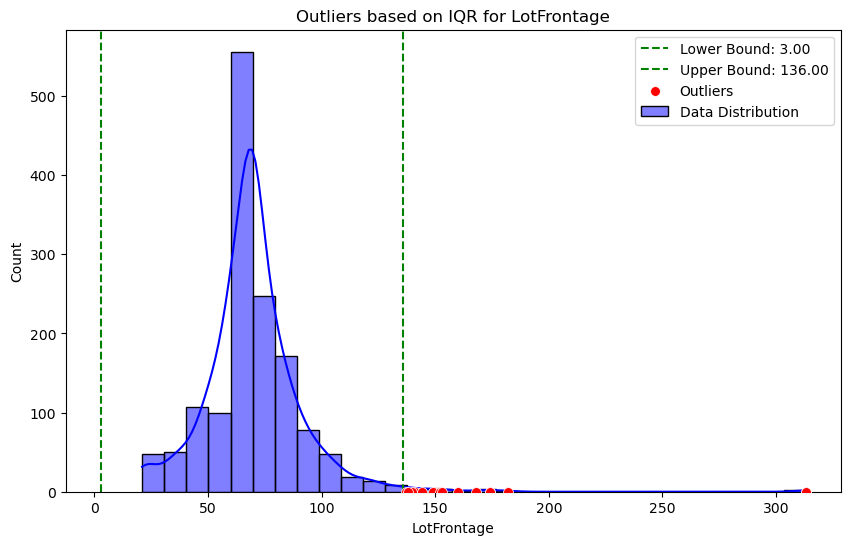


Column: LotArea
Outlier Values: [ 50271  31770  25419 159000  39104 215245 164660  53107  34650  70761
  53227  40094  32668  25095  46589  26178 115149  53504  28698  45600
  25286  27650  24090  25000  29959  35760  35133  32463  24682  36500
  63887  25339  57200  26142]


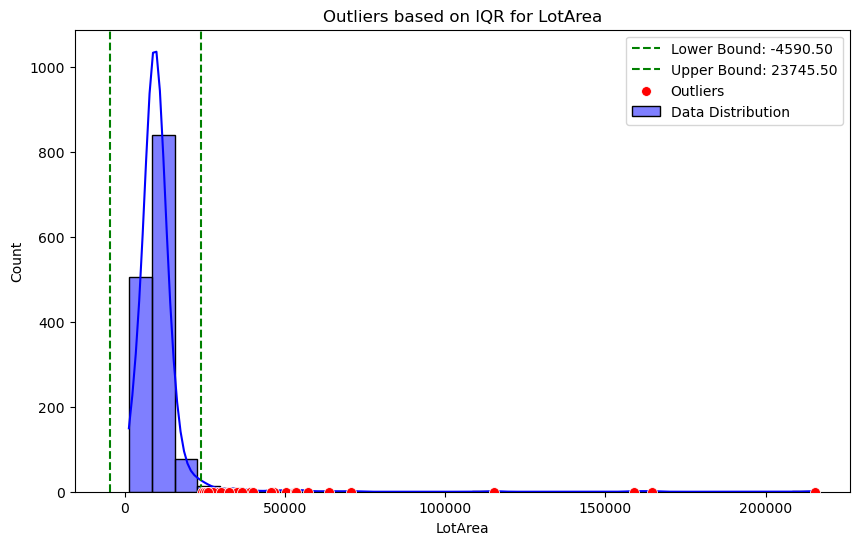


Column: MasVnrArea
Outlier Values: [1031. 1115.  768. 1129.  664.  748.  922. 1600.  870.  772.  921.  762.
  660. 1170.  894.  673.  860. 1047.  816.  760.  975.  660. 1378.  766.
  788.  796.  705.  731.]


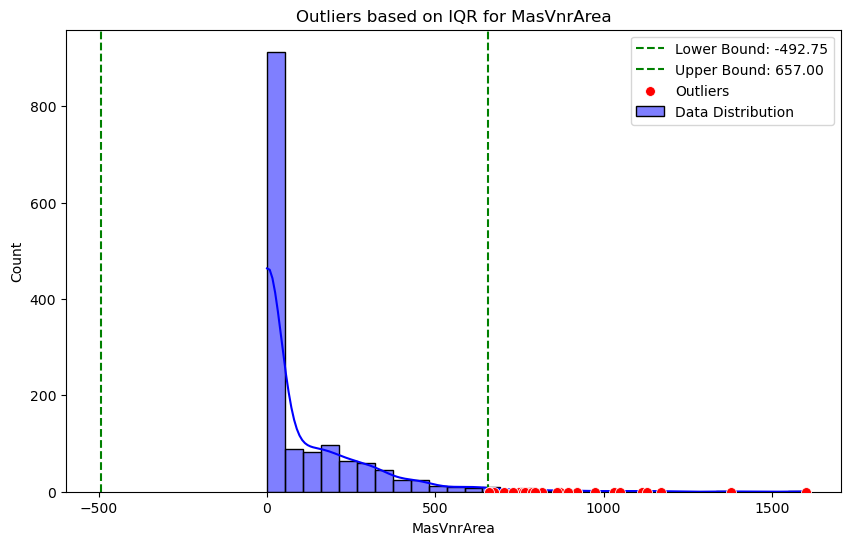


Column: BsmtFinSF1
Outlier Values: [5644]


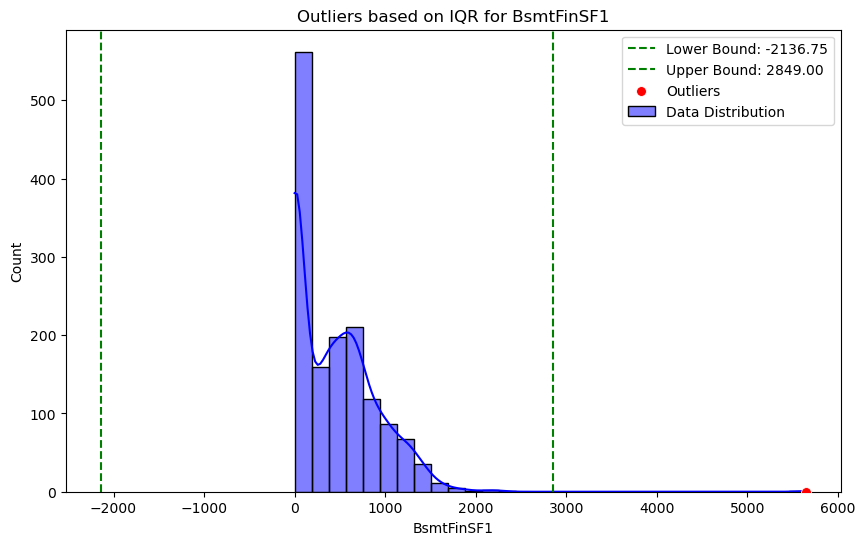


Column: BsmtFinSF2
Outlier Values: [  32  668  486   93  491  506  712  362   41  169  869  150  670   28
 1080  181  768  215  374  208  441  184  279  306  180  712  580  690
  692  228  125 1063  620  175  820 1474  264  479  147  232  380  544
  294  258  121  180  391  531  344  539  713  210  311 1120  165  532
  279   96  495  180  174 1127  139  202  645  123  551  219  606  147
  612  480  182  132  336  468  287   35  499  180  180  723  119  182
   40  551  117  239   80  472   64 1057  127  630  480  128  377  764
  345  539 1085  435  823  500  290  324  634  411  841 1061   93  466
  396  354  294  149  193  117  273  465  400  468   41  682   64  557
  230  106  791  240  287  547  391  469  177  108  374  600  492  211
  168   96 1031  438  375  144   81  906  608  276  661   68  173  972
  105  420  469  546  334  352  872  374  110  627  163 1029  290]


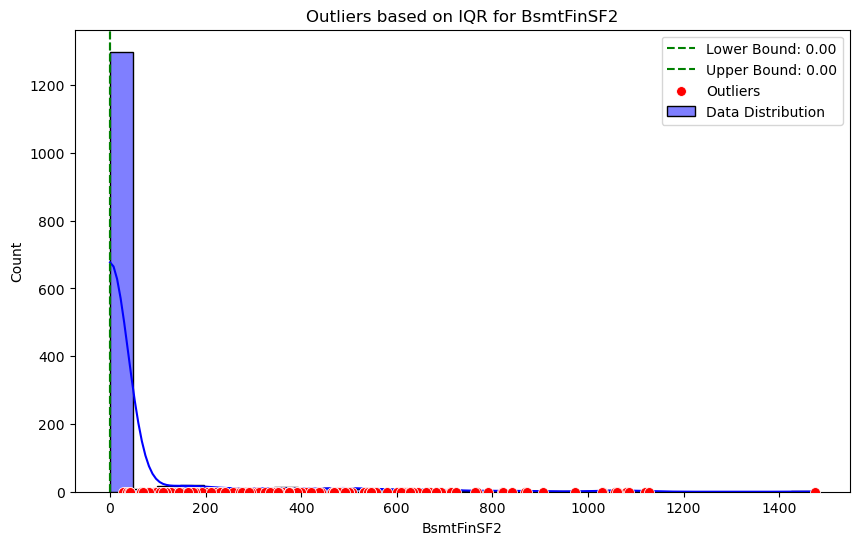


Column: TotalBsmtSF
Outlier Values: [3206 3094 3200 3138 6110]


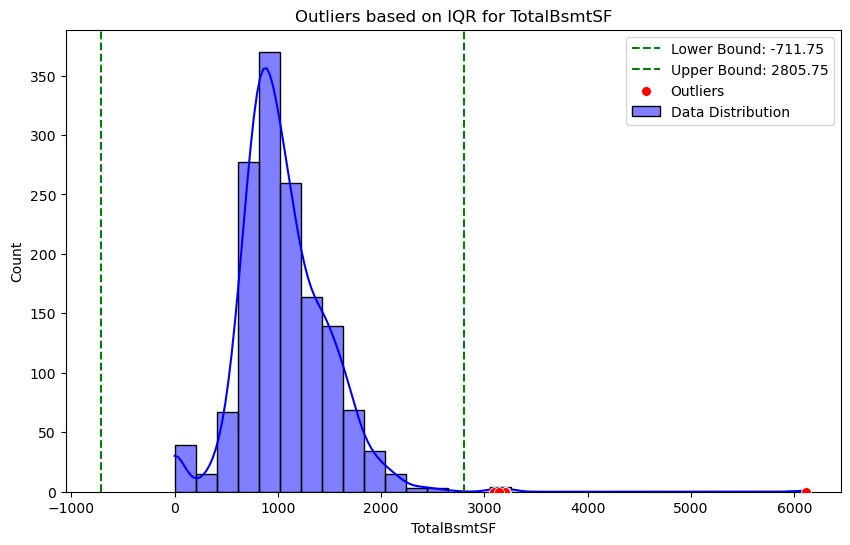


Column: 1stFlrSF
Outlier Values: [3228 3138 4692]


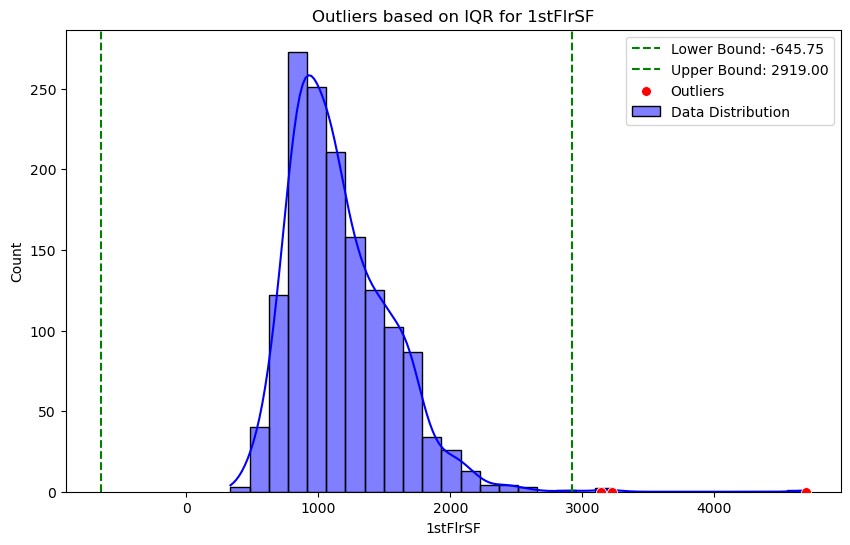


Column: LowQualFinSF
Outlier Values: [360 513 234 528 572 144 392 371 390 420 473 156 515 360  80  80  53 232
 481 120 514 397 479 205  80 384]


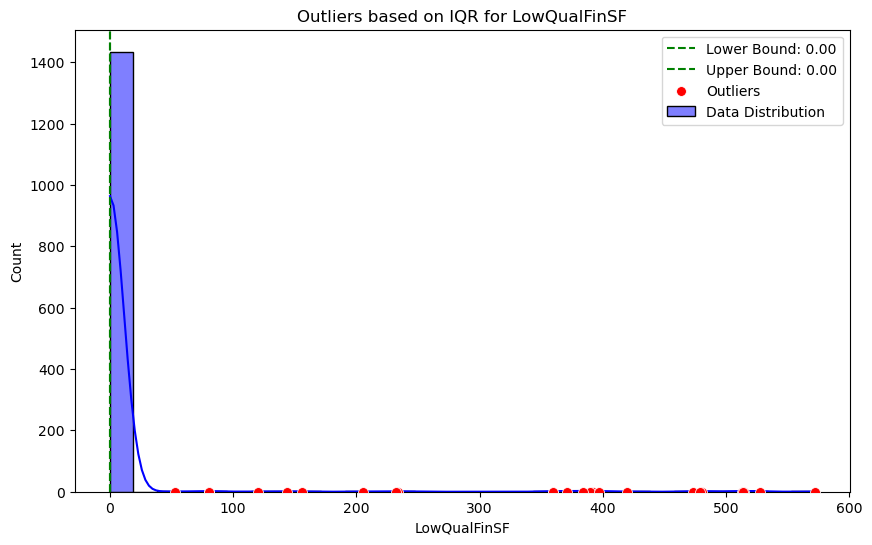


Column: GrLivArea
Outlier Values: [4676 4316 4476 5642]


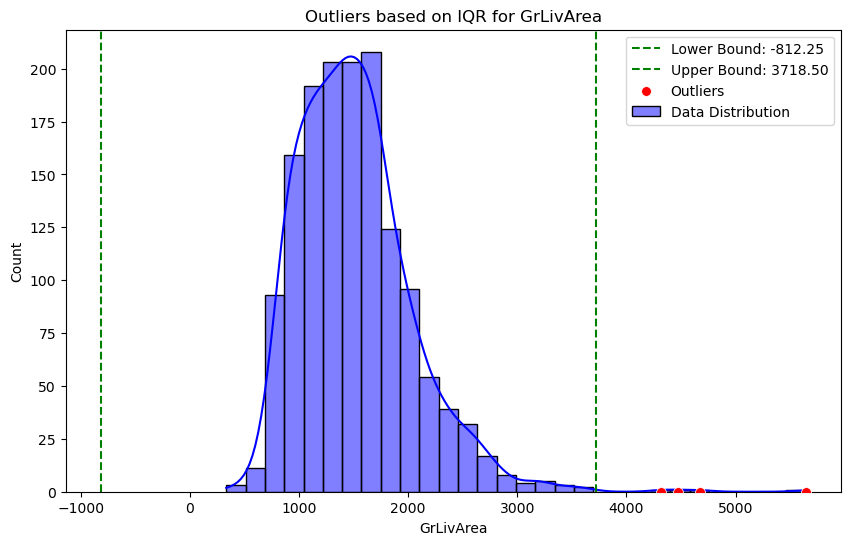


Column: BsmtHalfBath
Outlier Values: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]


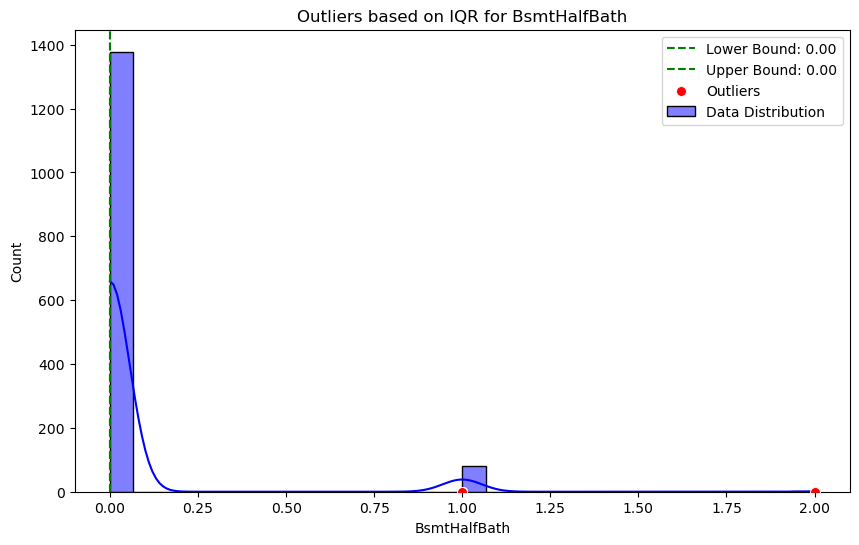


Column: BedroomAbvGr
Outlier Values: [8]


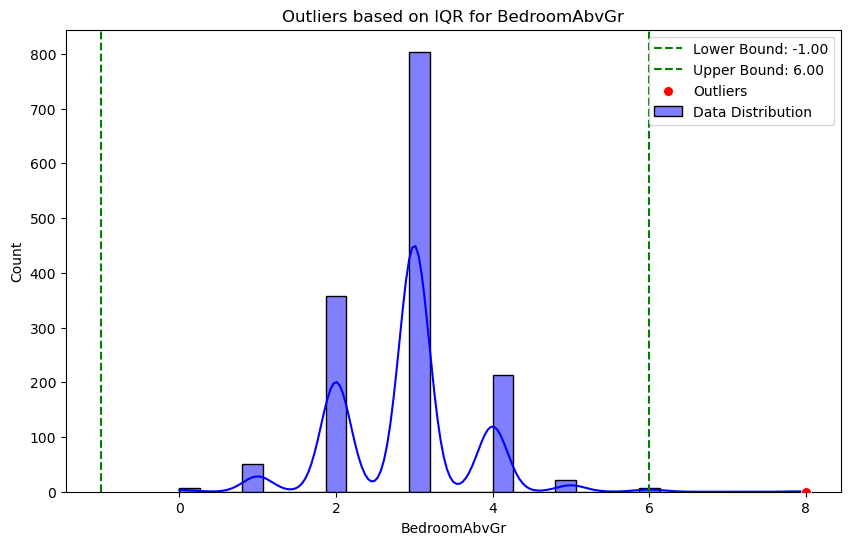


Column: KitchenAbvGr
Outlier Values: [2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2
 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


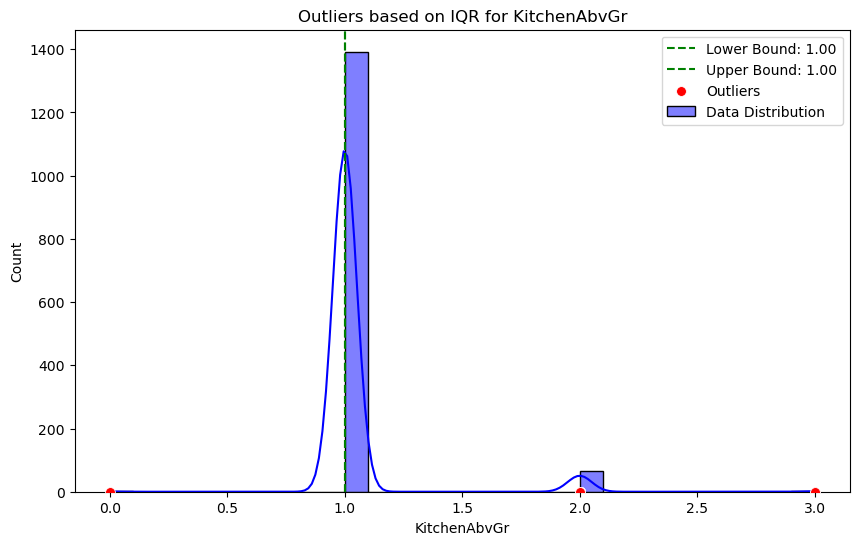


Column: TotRmsAbvGrd
Outlier Values: [14]


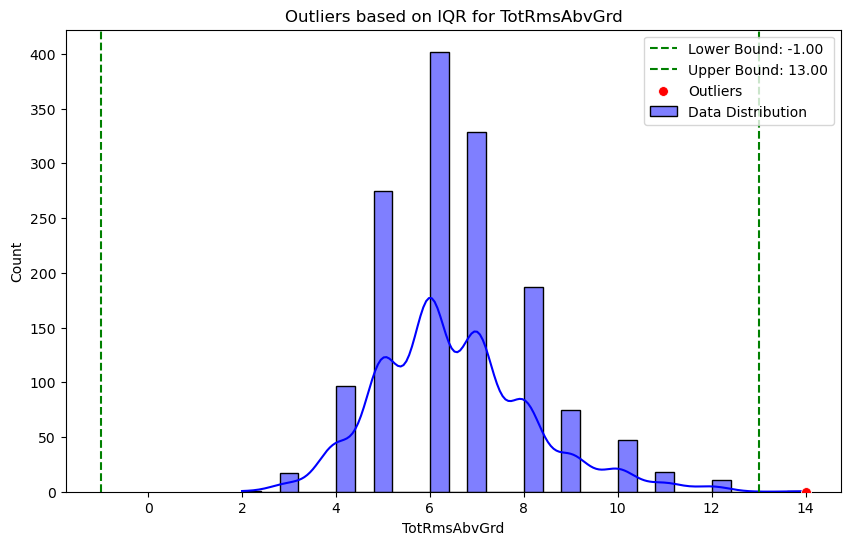


Column: GarageArea
Outlier Values: [1390 1356 1418]


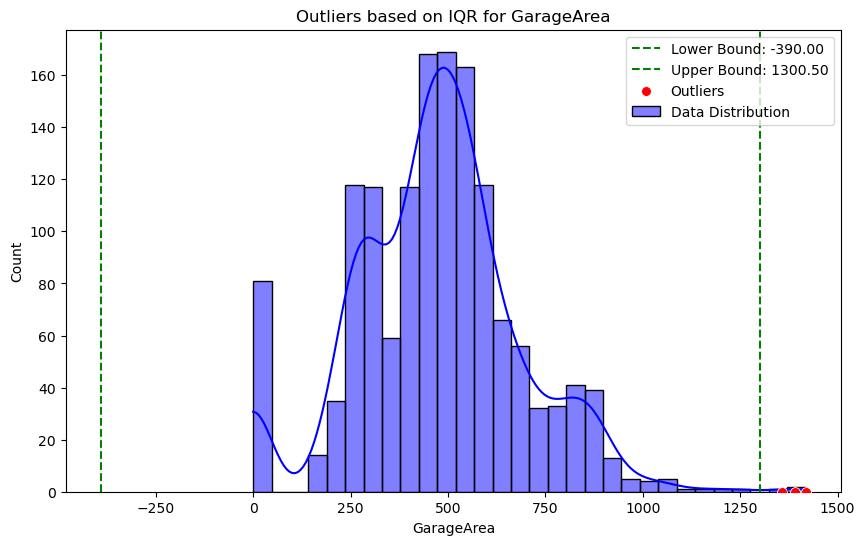


Column: WoodDeckSF
Outlier Values: [857 728 736]


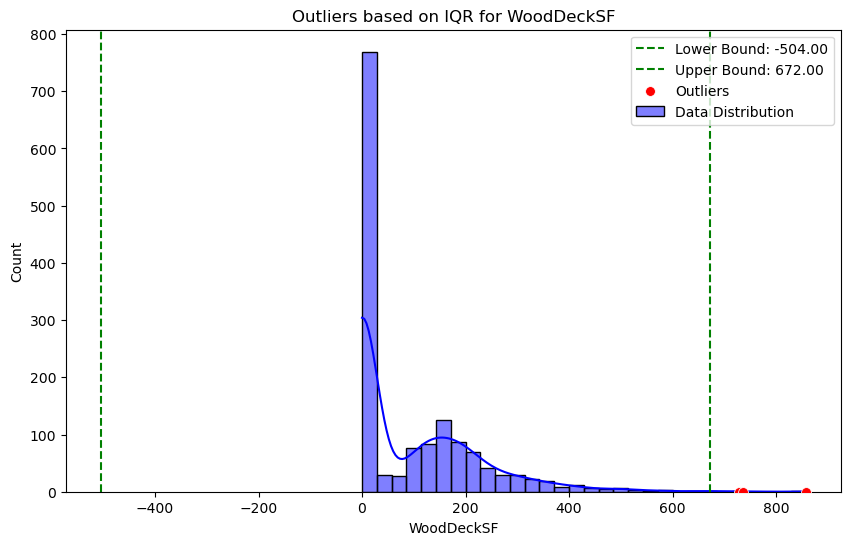


Column: OpenPorchSF
Outlier Values: [523 285 406 502 274 312 288 341 291 312 418 364 282 319 304 287 292 547]


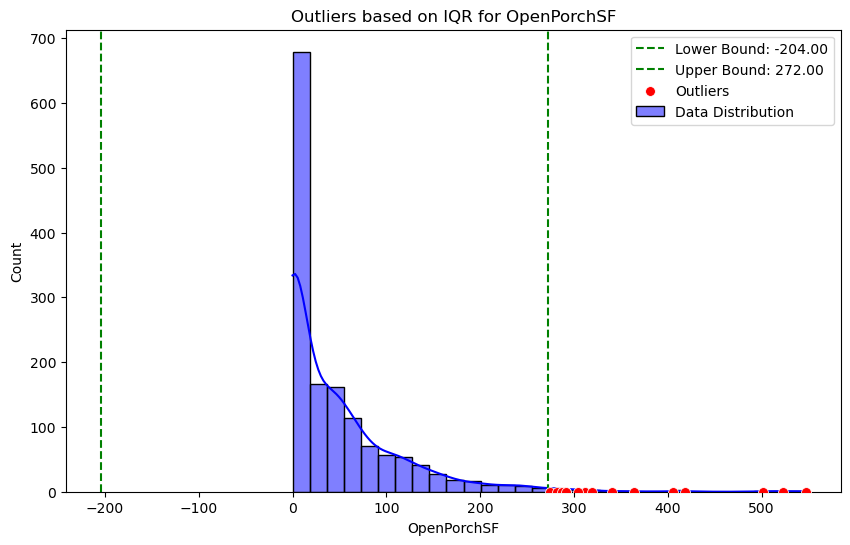


Column: EnclosedPorch
Outlier Values: [272 228 205 176 205  87 172 102  37 144  64 114 202 128 156  44  77 144
 192 144 140 180 228 128 183  39 184  40 552  30 126  96  60 150 120 202
  77 112 252  52 224 234 144 244 268 137  24 108 294 177 218 242  91 112
 160 130 184 126 169 105  34  96 248 236 120  32  80 115 291 184 116 158
 112 210  36 156 144 200  84 148 116 120 136 102 240  54 112  39 100  36
 189 293 164  40 216 239 112 252 240 180  67  90 120  56 112 129  40  98
 143 216 234 112 112  70 386 154 185 156 156 134 196 264 185 275  96 120
 112 116 230 254  68 194 192  34 150 164 112 224  32 318 244  48  94 138
 108 112 226 192 174 228  19 170 220 128  80 115 137 192 252 112  96 176
 216 176 214 280  96 116 102 190 236 192  84 330 208 145 259 126 264  81
 164  42 123 162 100 286 190 168  20 301 198  96 221 112 212  50 150 168
 112 160 114 216 154  99 158 216 252 112]


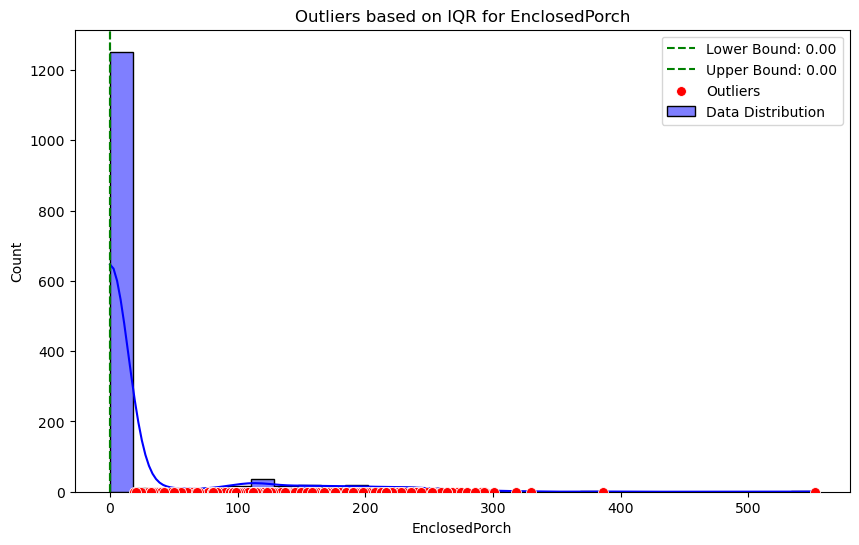


Column: 3SsnPorch
Outlier Values: [320 407 130 180 168 180 140 508 238 245 196 144 144 182 168 162  23 168
 216  96 216 153 290 304]


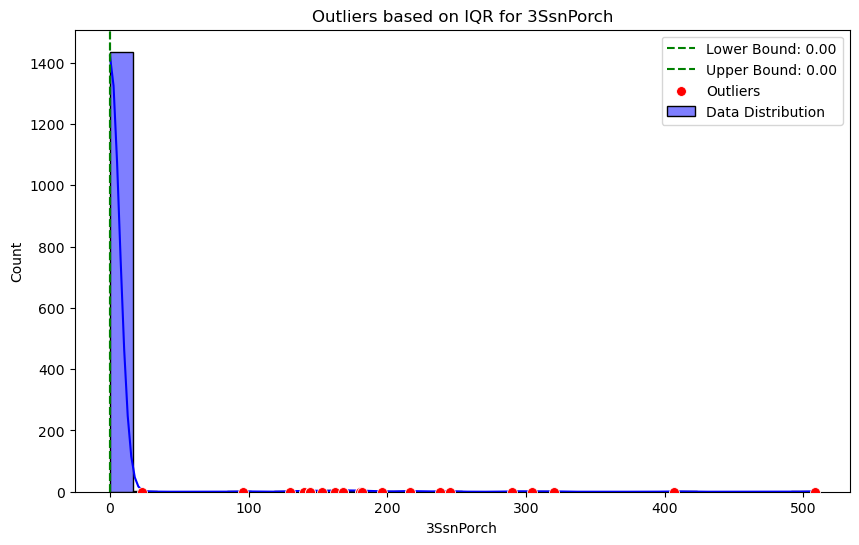


Column: ScreenPorch
Outlier Values: [176 198 291 252  99 184 168 130 142 192 410 224 266 170 154 153 144 142
 128 259 160 198 271 234 184 374 192 185 182  90 144 224 396 170 176 140
 276 192 180 161 168 145 200 122  95 144 120  60 120 126 189 260 147 385
 287 200 156 100 180 216 210 197 204 192 225 192 152 175 126 312 222 265
 224 322 120 190 233  63 147 180  53 143 189 189 189 192 160 160 126 100
 273 180  90 288 263 224 147 120  80 163  90 288 116 259 224 216 480 120
 178 440 155 168 220 119 165  40]


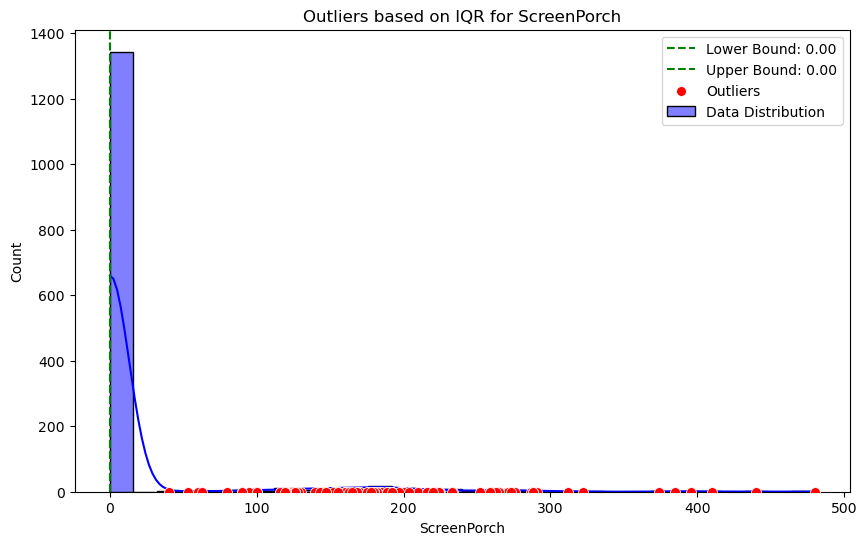


Column: PoolArea
Outlier Values: [512 648 576 555 480 519 738]


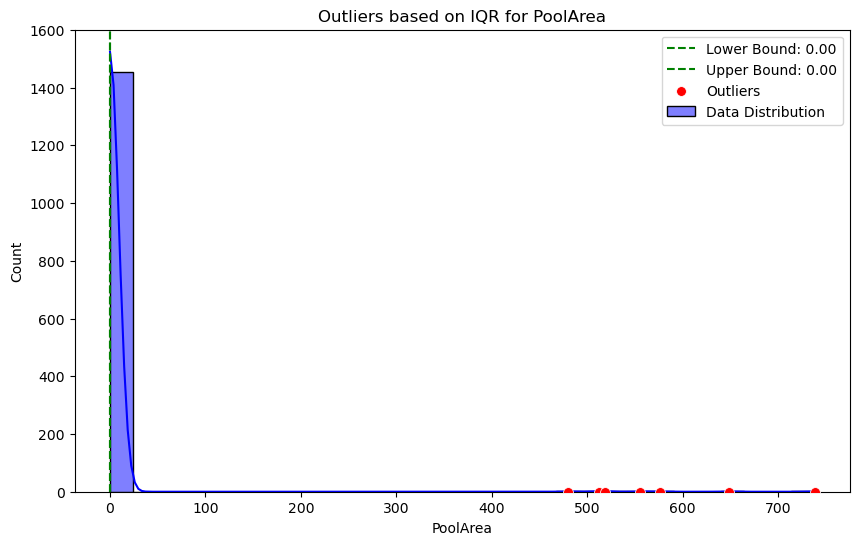


Column: MiscVal
Outlier Values: [  700   350   700   500   400   700   480   400   400   450   450   500
   450   700   400 15500  1200   800   480   400  2000  2000   600   500
   600   600  3500   500   400   450   500  1300  1200   500   400    54
   500   400   400  2000   620   400   560   500   700  1400   400  8300
   600  1150  2000  2500]


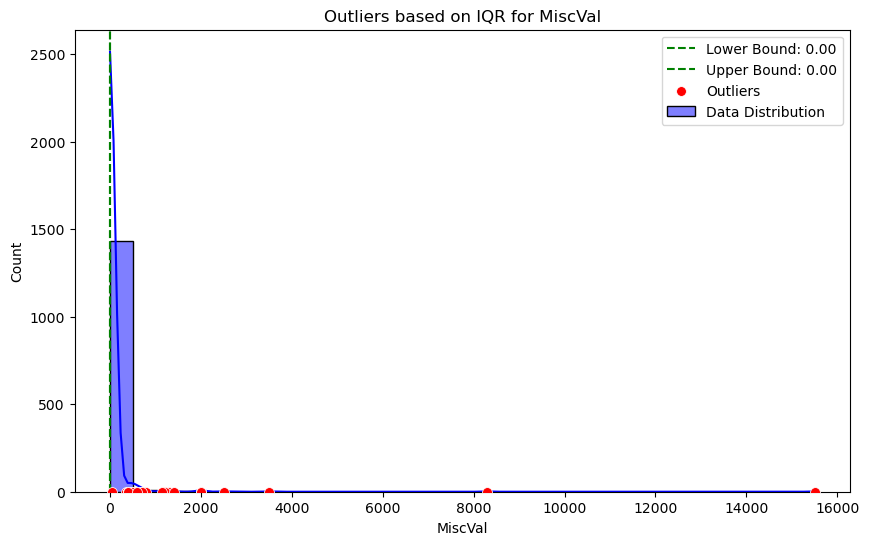

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def detect_and_visualize_outliers_iqr(df, data_description_dict):
    for field in df.columns:
        # Check if the feature type is 'continuous' in data_description_dict
        if data_description_dict.get(field, {}).get('Feature Type') == 'continuous':
            
            # Calculate Q1 (25th percentile) and Q3 (75th percentile)
            Q1 = df[field].quantile(0.25)
            Q3 = df[field].quantile(0.75)
            IQR = Q3 - Q1
            
            # Calculate the bounds for outliers
            lower_bound = Q1 - 3 * IQR
            upper_bound = Q3 + 3 * IQR
            
            # Identify outliers
            outliers = df[(df[field] < lower_bound) | (df[field] > upper_bound)]
            
            if len(outliers) > 0:
                print(f"\nColumn: {field}")
                print(f"Outlier Values: {outliers[field].values}")
                
                # Plot the distribution of the data
                plt.figure(figsize=(10, 6))
                
                # Plot histogram with KDE for data distribution
                sns.histplot(df[field], kde=True, color='blue', label='Data Distribution', bins=30)
                
                # Plot the bounds for IQR
                plt.axvline(lower_bound, color='green', linestyle='dashed', label=f'Lower Bound: {lower_bound:.2f}')
                plt.axvline(upper_bound, color='green', linestyle='dashed', label=f'Upper Bound: {upper_bound:.2f}')
                
                # Highlight the outliers in red
                sns.scatterplot(x=outliers[field], y=np.zeros_like(outliers[field]), color='red', s=50, label='Outliers', zorder=5)
                
                # Add title and labels
                plt.title(f"Outliers based on IQR for {field}")
                plt.xlabel(f"{field}")
                plt.ylabel("Count")
                plt.legend()
                
                # Show the plot
                plt.show()

# Example usage:
# Assuming df is your DataFrame and data_description_dict contains the feature types
detect_and_visualize_outliers_iqr(df, data_description_dict)


todo:
I dont know how to handle outliers and whether is makes a real difference at the end

Highly Skewed Features:
{'LotFrontage': 2.4091466665496006, 'LotArea': 12.207687851233496, 'MasVnrArea': 2.6776164510820997, 'BsmtFinSF1': 1.685503071910789, 'BsmtFinSF2': 4.255261108933303, 'TotalBsmtSF': 1.5242545490627664, '1stFlrSF': 1.3767566220336365, 'LowQualFinSF': 9.011341288465387, 'GrLivArea': 1.3665603560164552, 'BsmtHalfBath': 4.103402697955168, 'WoodDeckSF': 1.5413757571931312, 'OpenPorchSF': 2.3643417403694404, 'EnclosedPorch': 3.08987190371177, '3SsnPorch': 10.304342032693112, 'ScreenPorch': 4.122213743143115, 'PoolArea': 14.828373640750588, 'MiscVal': 24.476794188821916, 'KitchenAbvGr': 4.488396777072859}
LotFrontage: Skewness = 2.41


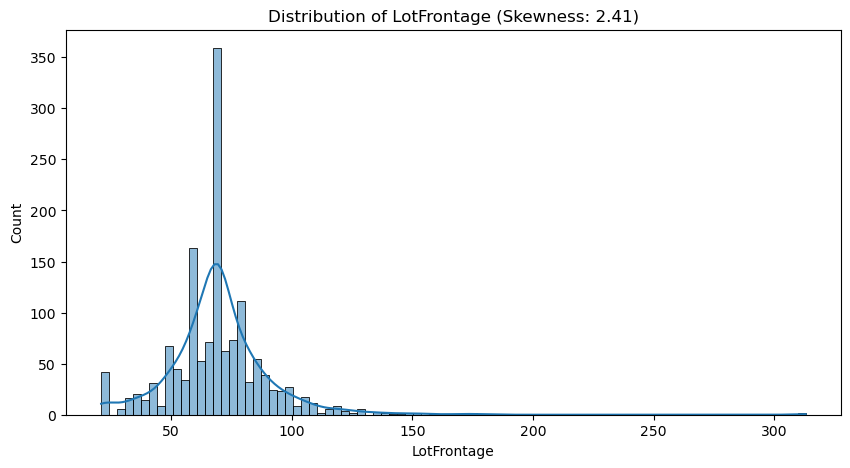

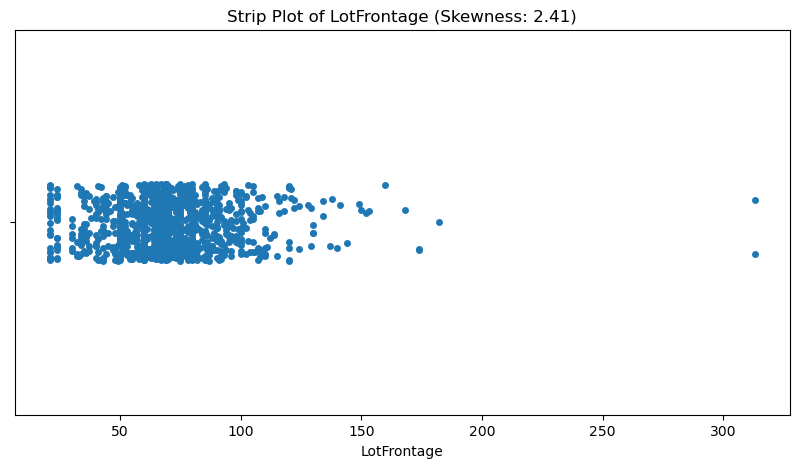

LotArea: Skewness = 12.21


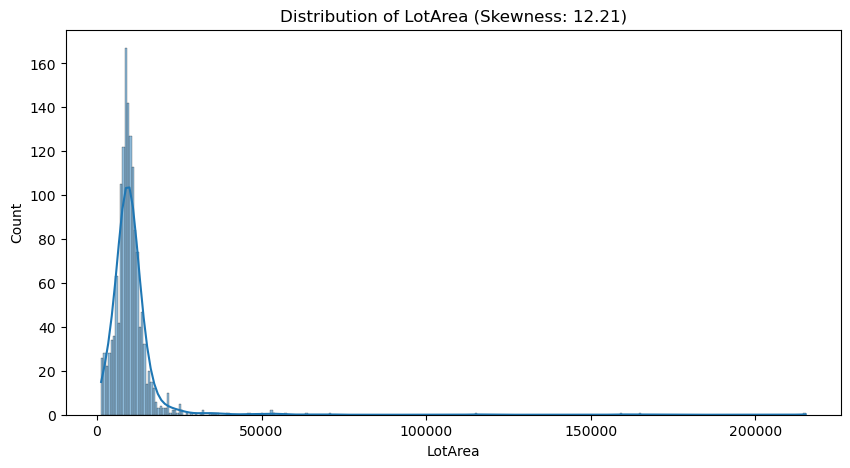

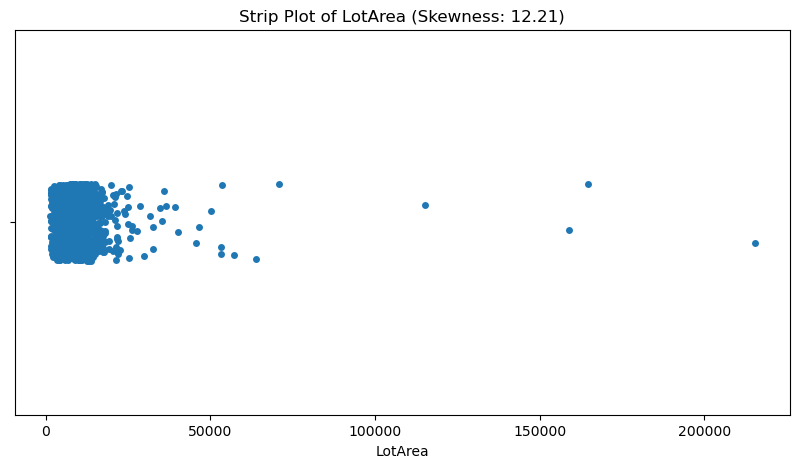

MasVnrArea: Skewness = 2.68


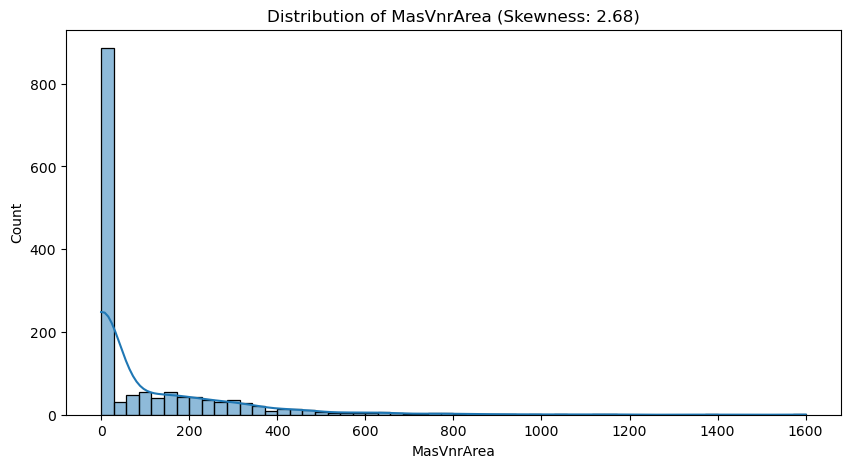

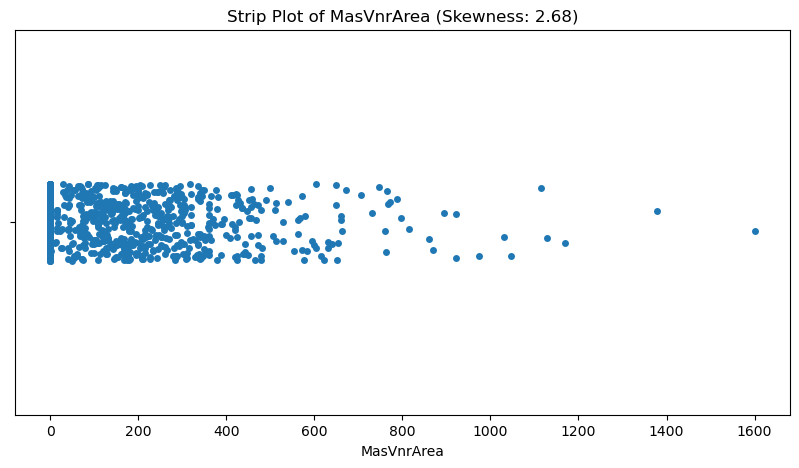

BsmtFinSF1: Skewness = 1.69


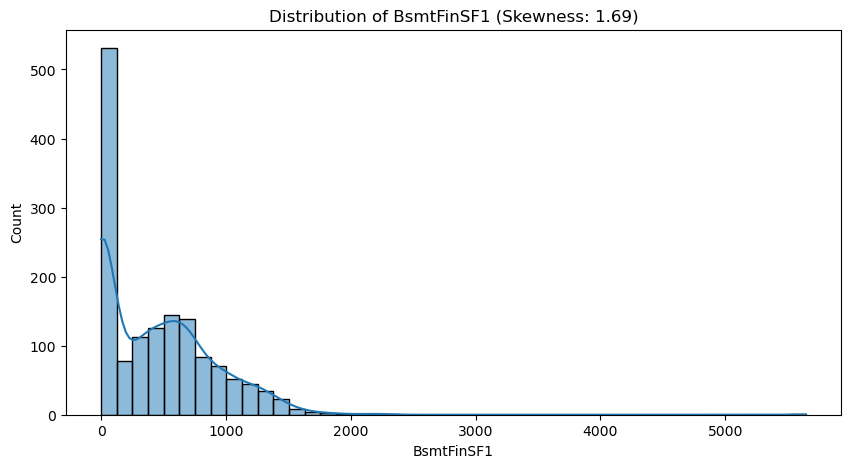

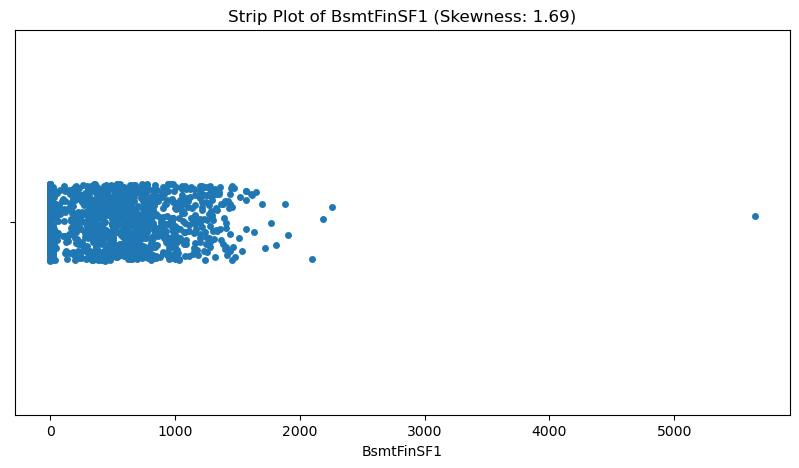

BsmtFinSF2: Skewness = 4.26


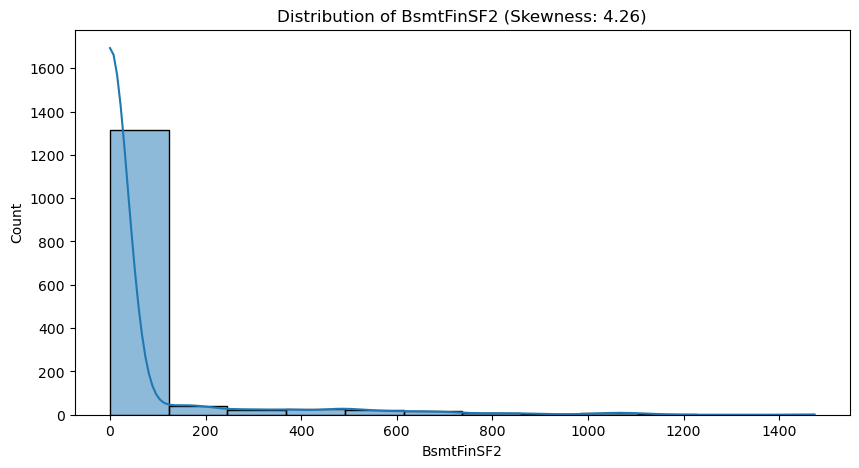

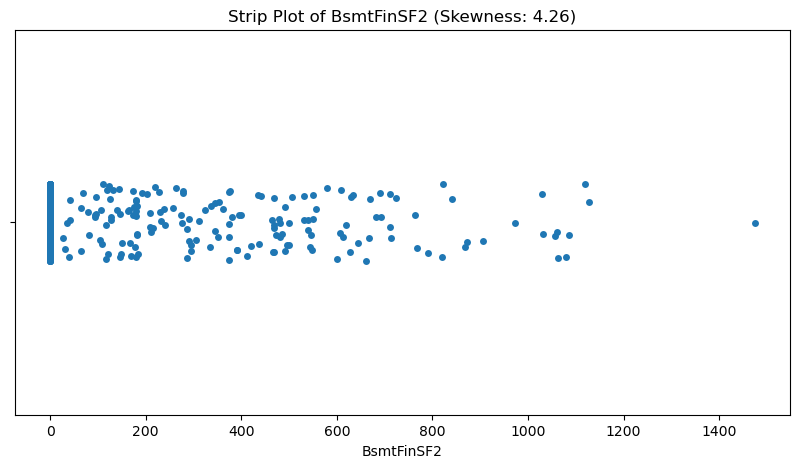

TotalBsmtSF: Skewness = 1.52


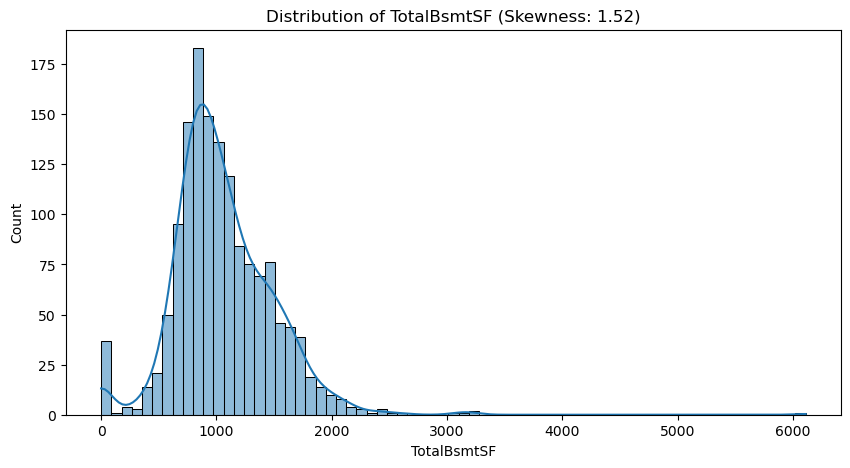

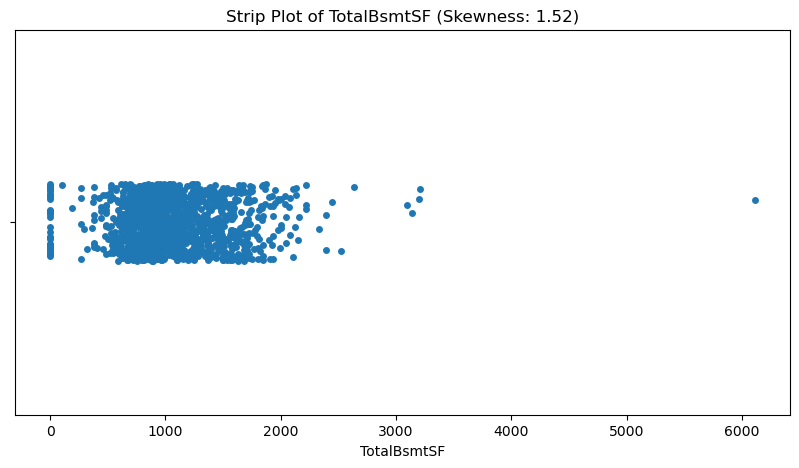

1stFlrSF: Skewness = 1.38


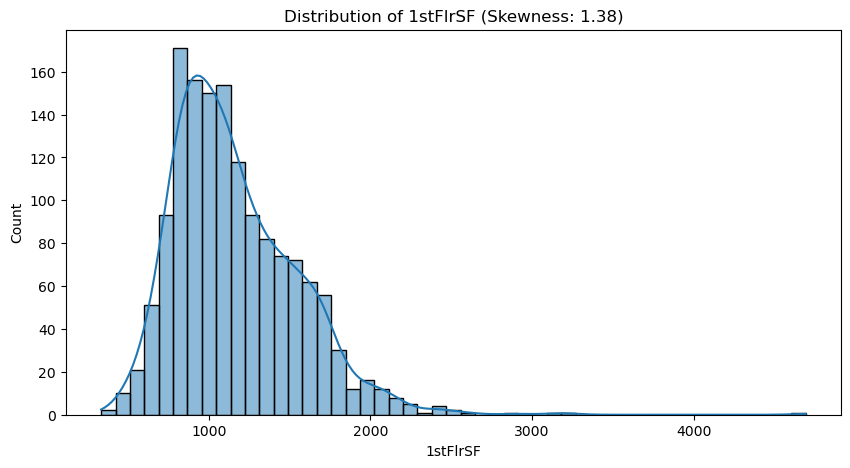

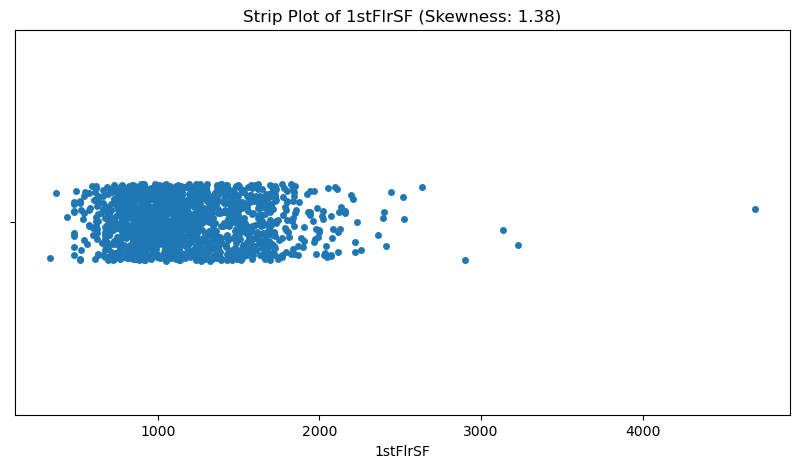

LowQualFinSF: Skewness = 9.01


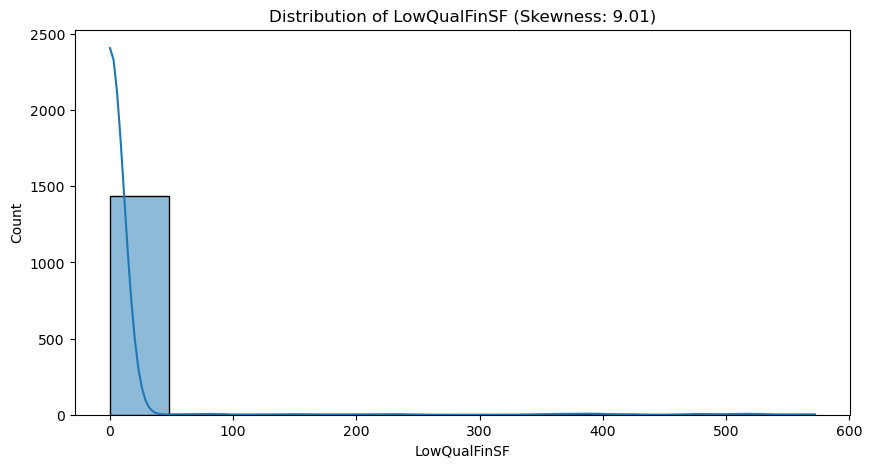

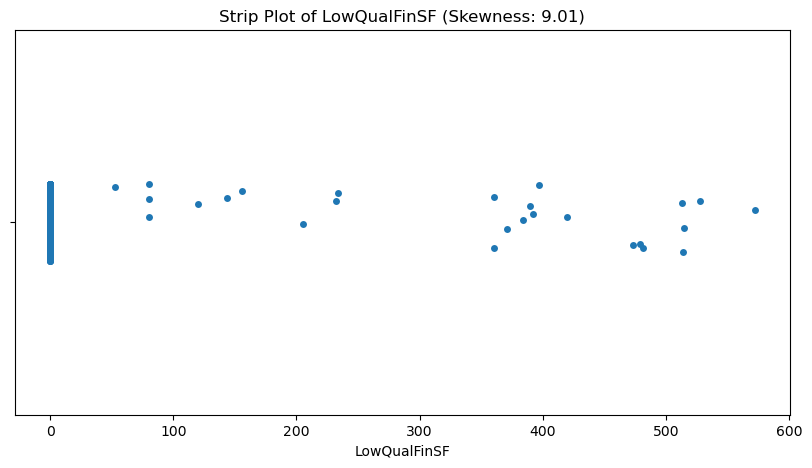

GrLivArea: Skewness = 1.37


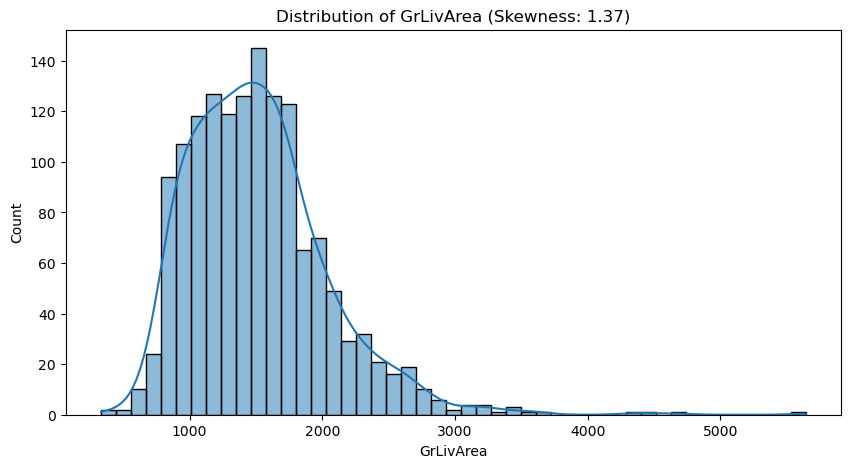

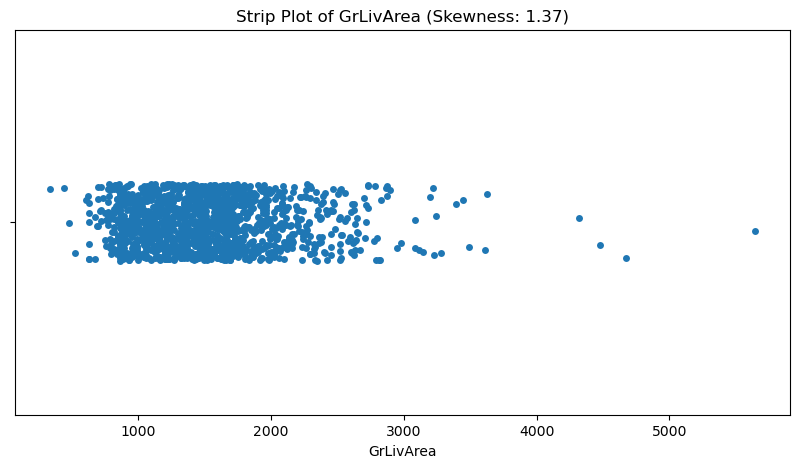

BsmtHalfBath: Skewness = 4.10


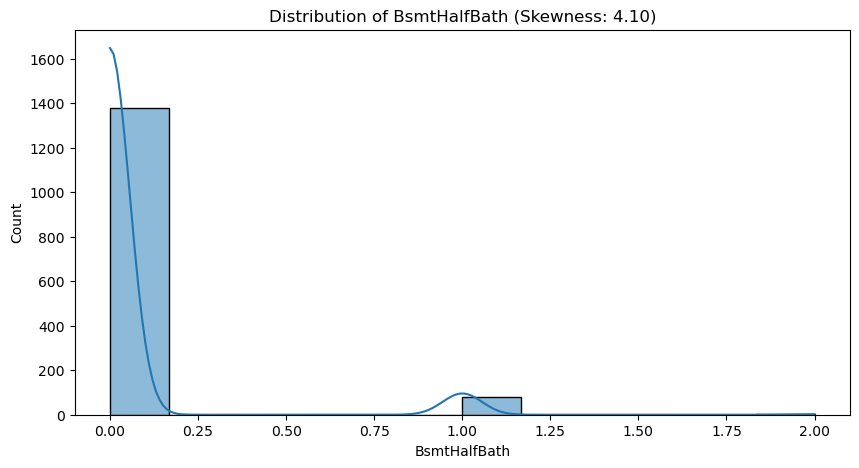

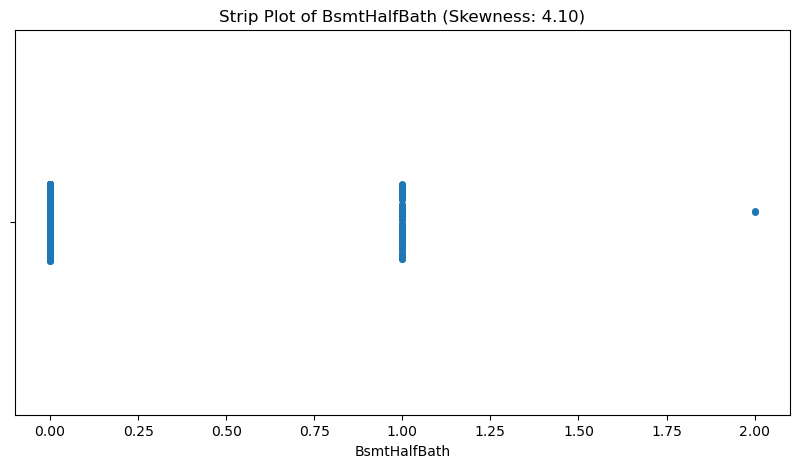

WoodDeckSF: Skewness = 1.54


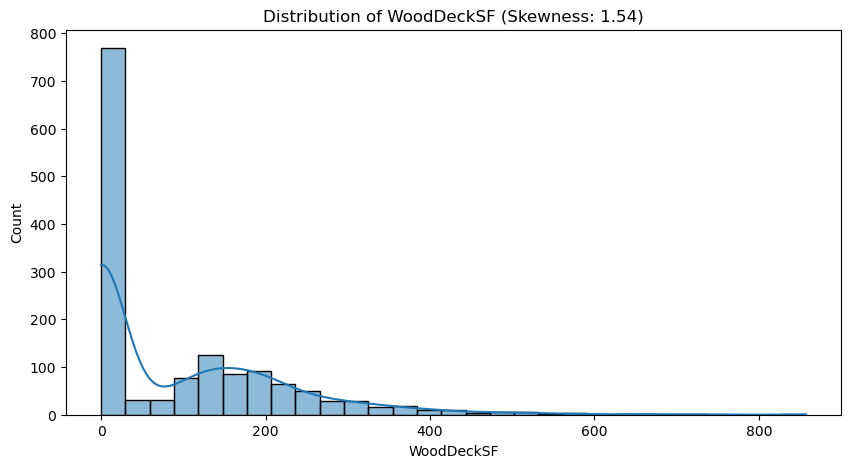

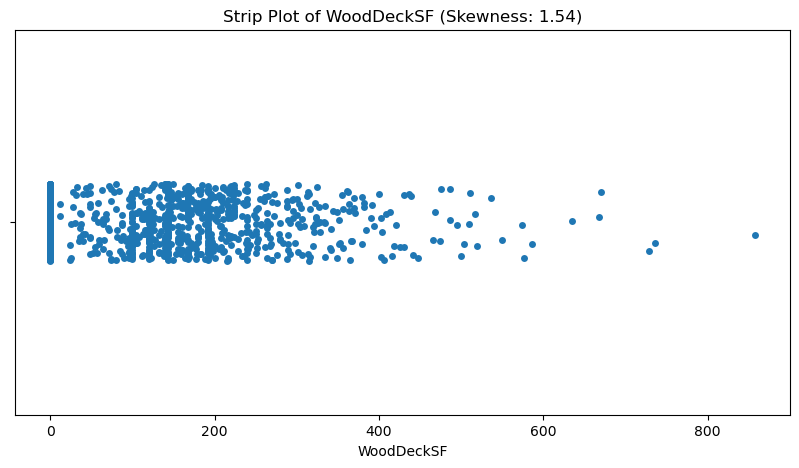

OpenPorchSF: Skewness = 2.36


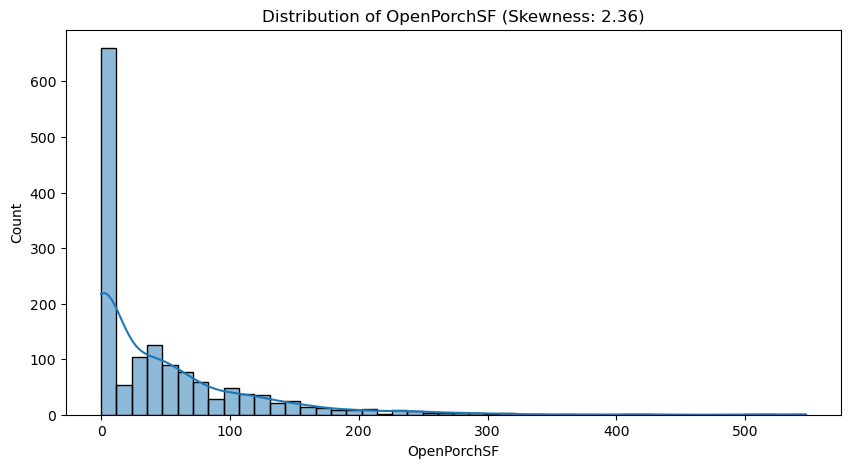

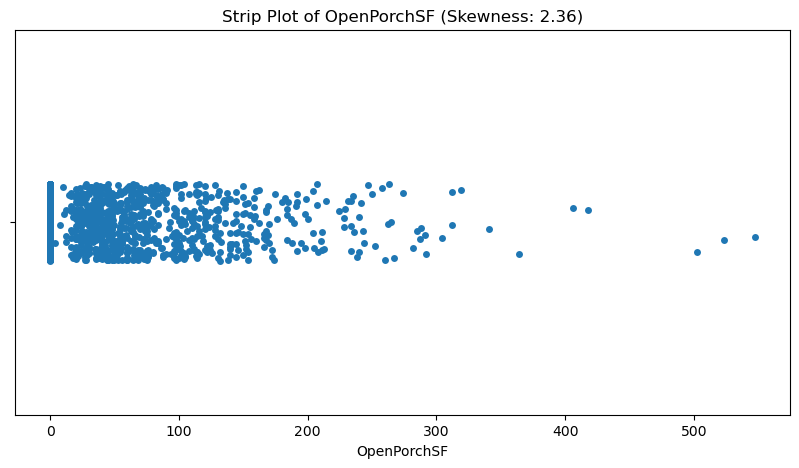

EnclosedPorch: Skewness = 3.09


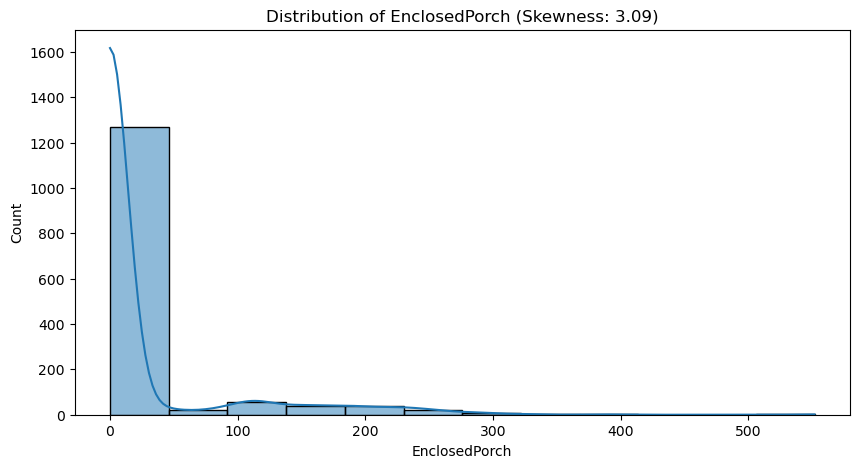

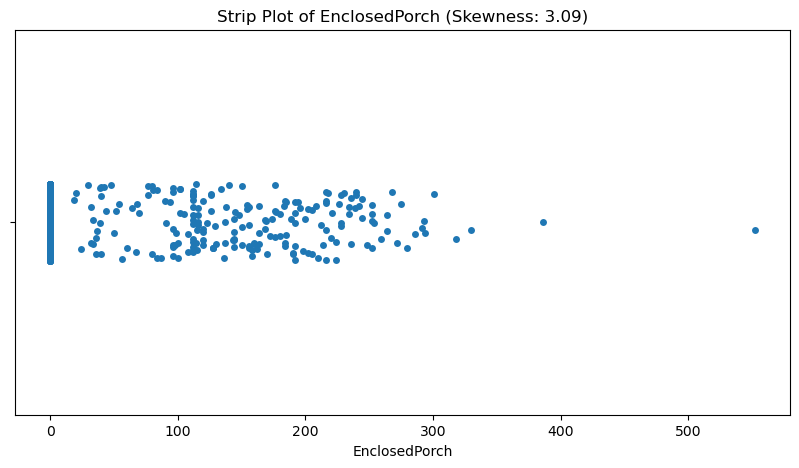

3SsnPorch: Skewness = 10.30


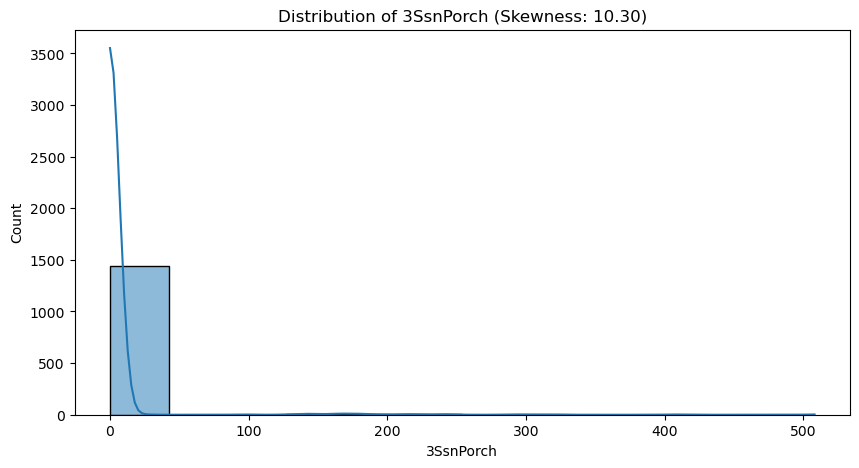

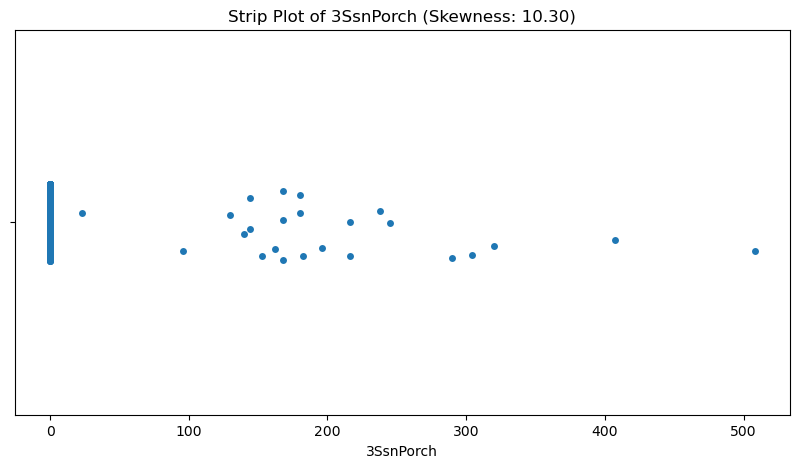

ScreenPorch: Skewness = 4.12


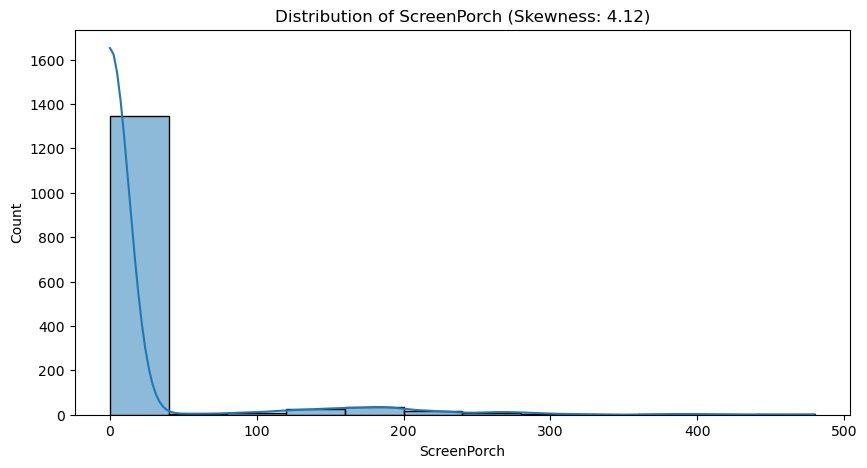

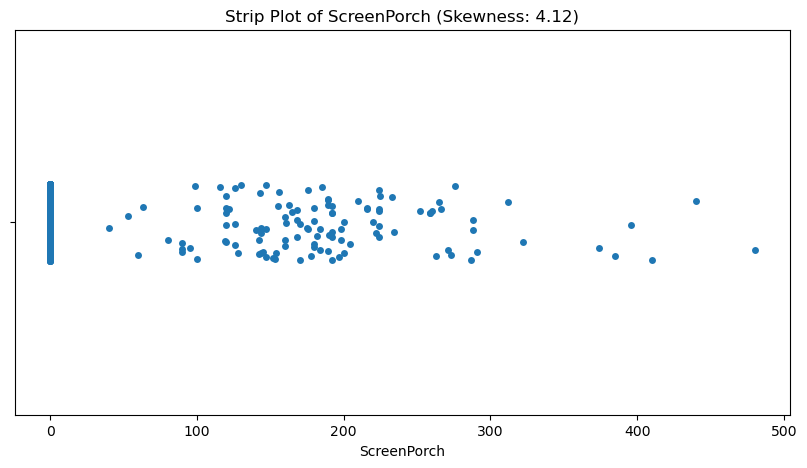

PoolArea: Skewness = 14.83


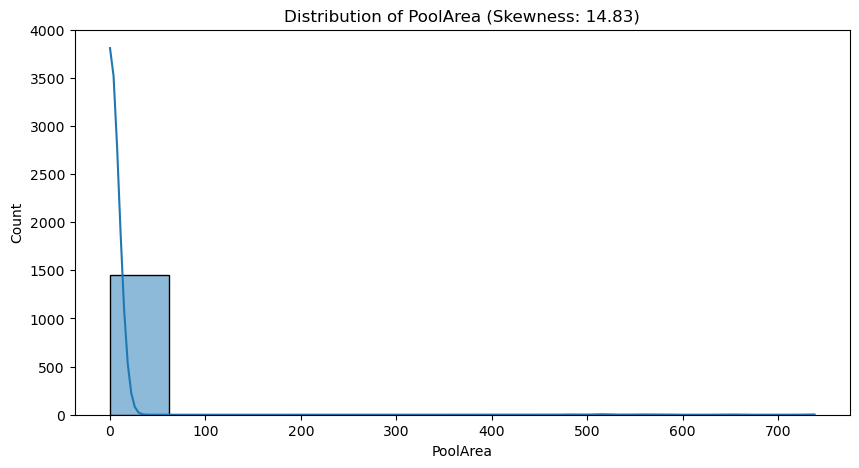

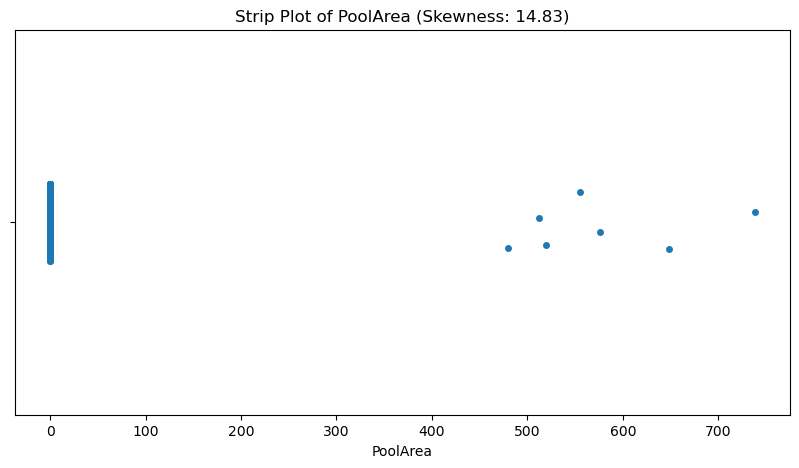

MiscVal: Skewness = 24.48


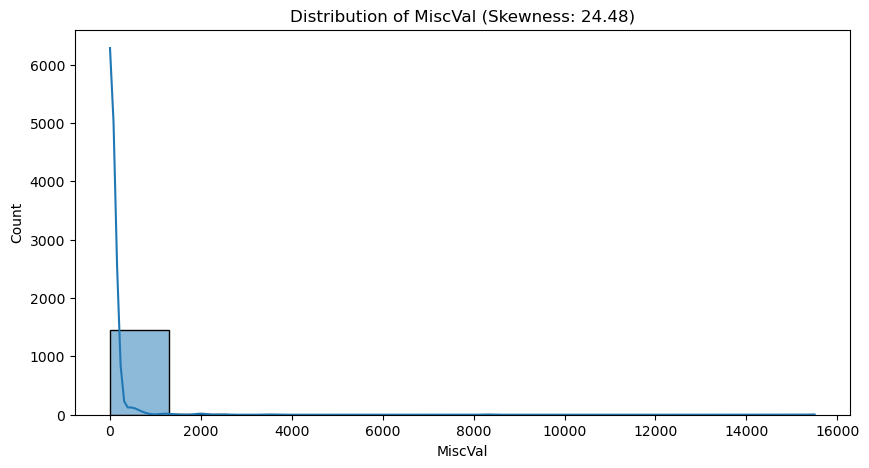

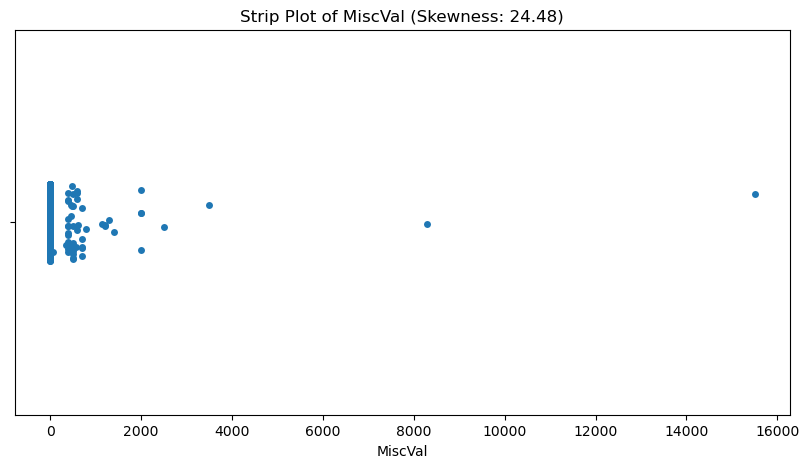

KitchenAbvGr: Skewness = 4.49


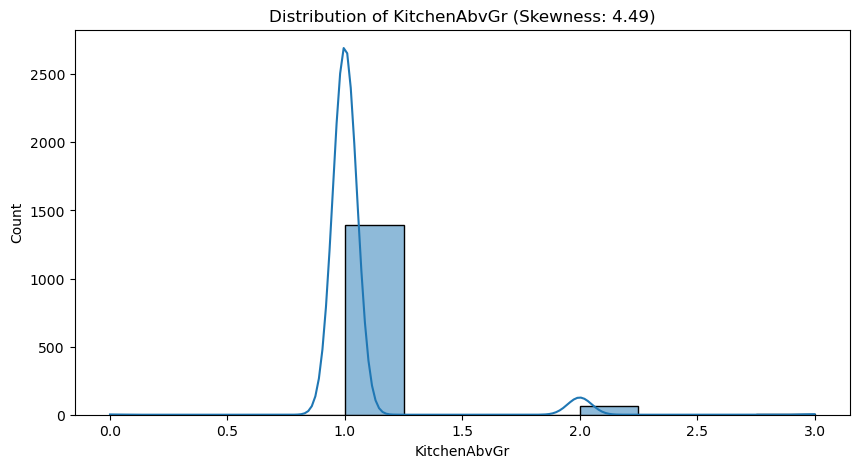

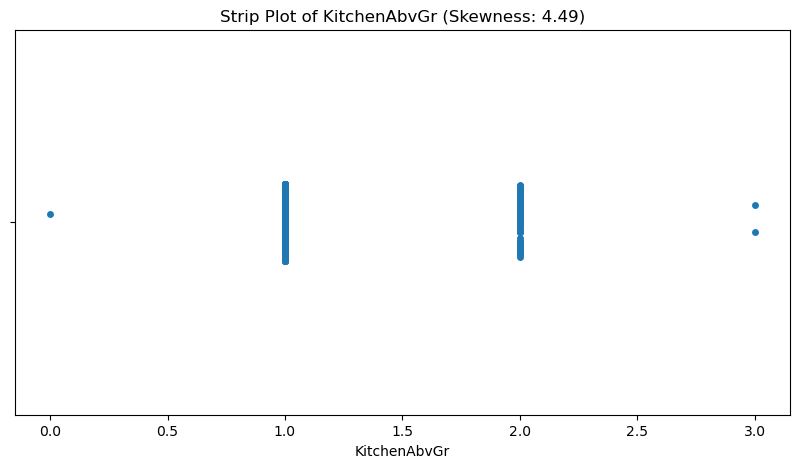

In [37]:
#to find highly skewed features

# Set skewness threshold for identifying highly skewed features
skew_threshold = 1

# List of continuous features (you might get these from your data_description_dict)
continuous_features = [col for col, data in data_description_dict.items() if data['Feature Type'] == 'continuous']

# Dictionary to store skewness values for each continuous feature
skewed_features = {}

# Calculate skewness and identify highly skewed features
for feature in continuous_features:
    skewness = df[feature].skew()
    if abs(skewness) > skew_threshold:
        skewed_features[feature] = skewness

# Display skewed features
print("Highly Skewed Features:")
print(skewed_features)
for feature, skewness in skewed_features.items():
    print(f"{feature}: Skewness = {skewness:.2f}")

    # Plot histogram and KDE for each highly skewed feature
    plt.figure(figsize=(10, 5))
    sns.histplot(df[feature], kde=True)
    plt.title(f"Distribution of {feature} (Skewness: {skewness:.2f})")
    plt.show()

    plt.figure(figsize=(10, 5))
    sns.stripplot(x=df[feature], jitter=True)
    plt.title(f"Strip Plot of {feature} (Skewness: {skewness:.2f})")
    plt.xlabel(feature)
    plt.show()


In [36]:
print(list(df['LotFrontage']))

[65.0, 80.0, 68.0, 60.0, 84.0, 85.0, 75.0, 69.0, 51.0, 50.0, 70.0, 85.0, 69.0, 91.0, 69.0, 51.0, 69.0, 72.0, 66.0, 70.0, 101.0, 57.0, 75.0, 44.0, 69.0, 110.0, 60.0, 98.0, 47.0, 60.0, 50.0, 69.0, 85.0, 70.0, 60.0, 108.0, 112.0, 74.0, 68.0, 65.0, 84.0, 115.0, 69.0, 69.0, 70.0, 61.0, 48.0, 84.0, 33.0, 66.0, 69.0, 52.0, 110.0, 68.0, 60.0, 100.0, 24.0, 89.0, 66.0, 60.0, 63.0, 60.0, 44.0, 50.0, 69.0, 76.0, 69.0, 72.0, 47.0, 81.0, 95.0, 69.0, 74.0, 85.0, 60.0, 21.0, 69.0, 50.0, 72.0, 60.0, 100.0, 32.0, 78.0, 80.0, 69.0, 121.0, 122.0, 40.0, 105.0, 60.0, 60.0, 85.0, 80.0, 60.0, 69.0, 69.0, 78.0, 73.0, 85.0, 77.0, 69.0, 77.0, 64.0, 94.0, 69.0, 75.0, 60.0, 50.0, 85.0, 105.0, 75.0, 69.0, 77.0, 69.0, 61.0, 34.0, 69.0, 74.0, 90.0, 65.0, 69.0, 50.0, 75.0, 55.0, 48.0, 60.0, 69.0, 55.0, 69.0, 69.0, 88.0, 69.0, 75.0, 69.0, 78.0, 80.0, 69.0, 82.0, 73.0, 65.0, 70.0, 78.0, 71.0, 78.0, 70.0, 24.0, 51.0, 69.0, 63.0, 69.0, 120.0, 107.0, 69.0, 69.0, 84.0, 60.0, 60.0, 92.0, 100.0, 134.0, 69.0, 110.0, 95.0, 55.0

Dimension Reduction (should it be part of the EDA roadmap??): Feature engineering, such as log transformations or encoding, ensures that your features are represented in a way that is meaningful for the model. PCA, feature importance, and similar techniques work best when features are already in a form that the model can interpret.
For instance, scaling and encoding allow PCA to treat all features on a comparable scale, while transformations (like log for skewed data) reduce noise and make the features better suited for linear techniques.

## Standalone Purpose of EDA

EDA is used to:

1. **Understand the Data**: Helps you get a sense of the data, identify trends, patterns, and relationships between variables, and discover the overall structure.
2. **Identify Data Quality Issues**: Uncover missing data, outliers, or incorrect data types that need cleaning.
3. **Guide Feature Engineering**: Informs which features may need transformation, scaling, or encoding for machine learning models.
4. **Hypothesis Generation**: Helps formulate hypotheses about the data and develop insights that guide the rest of the analysis.
5. **Reporting Insights**: In some cases, especially in business analytics, EDA alone might be sufficient to answer key questions. If the data reveals insights, these can be reported without needing to build a predictive model.

---

## Next Steps After EDA (for ML Workflow)

After performing EDA, you typically move into the data preprocessing stage, which feeds directly into the machine learning pipeline. Here's an outline of the steps after EDA:

### 1. Data Preprocessing
This is where you clean and transform your data based on insights from EDA:

- **Handle Missing Data**: Impute missing values (e.g., mean, median, mode, or specific values) or remove rows/columns if necessary.
- **Outlier Treatment**: Handle outliers that can negatively impact model performance (e.g., remove or transform them).
- **Feature Scaling**: Normalize or standardize features, especially for algorithms sensitive to feature scaling (e.g., SVM, KNN).
- **Feature Encoding**: Convert categorical variables into numerical format (e.g., One-Hot Encoding, Label Encoding).
- **Feature Transformation**: Apply log, square root, or polynomial transformations to features if necessary (especially for skewed data).
- **Feature Engineering**: Create new features or modify existing ones based on domain knowledge or insights from EDA.

### 2. Feature Selection
Based on the results of EDA, you might decide to select or reduce features before feeding them into the model:

- **Filter Methods**: Use correlation matrices, variance thresholds, or statistical tests to identify irrelevant or redundant features.
- **Wrapper Methods**: Use techniques like recursive feature elimination (RFE) to select features.
- **Embedded Methods**: Use models like decision trees or Lasso (L1 regularization) that automatically select important features during training.

### 3. Splitting Data (Train/Test/Validation)
Split your dataset into training, validation, and test sets:

- **Training Set**: Used to train the machine learning model.
- **Validation Set**: Used for hyperparameter tuning and model evaluation during training.
- **Test Set**: A separate dataset to evaluate the final model's performance after training.

### 4. Model Selection
Select a few machine learning models based on the type of problem:

- **Classification**: Logistic regression, decision trees, random forests, support vector machines, etc.
- **Regression**: Linear regression, decision trees, random forests, XGBoost, etc.
- **Clustering**: K-means, hierarchical clustering, DBSCAN, etc.

### 5. Model Training
Train multiple models and compare performance:

- Use cross-validation to avoid overfitting and assess how well your model generalizes to unseen data.
- Fine-tune hyperparameters using techniques like grid search or random search.

### 6. Model Evaluation
Evaluate your models using appropriate metrics:

- **For Classification**: Accuracy, precision, recall, F1-score, AUC-ROC.
- **For Regression**: Mean squared error (MSE), root mean squared error (RMSE), R-squared.
- **For Clustering**: Silhouette score, Davies–Bouldin index.

### 7. Hyperparameter Tuning
Fine-tune your model’s hyperparameters using validation data:

- Use grid search, random search, or more advanced methods like Bayesian optimization to find the best combination of hyperparameters.

### 8. Final Model Selection and Testing
Evaluate the final model on the test set to get an estimate of its performance on unseen data.

### 9. Model Deployment
After selecting the best model, prepare it for deployment:

- Save the model (using `pickle`, `joblib`, etc.).
- Create an API or integrate it into a system for real-time or batch predictions.

### 10. Model Monitoring and Maintenance
After deployment, monitor the model’s performance over time to ensure it still meets performance requirements. Retrain as needed if model performance degrades (concept drift).

---

## Conclusion

While EDA can be a standalone process in some cases, its primary purpose in machine learning workflows is to prepare the data and gain insights that will guide the next steps in model building. The end goal is to clean, transform, and select the best features so that the machine learning algorithms can perform optimally.
